# Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', 100) # to see more columns of df.head()
np.random.seed(31415) # set the np random seed for the reproducibility

# some utilities
from math import sqrt
from math import log

In [2]:
import xgboost
print (xgboost.__version__)
import sklearn
print (sklearn.__version__)

2.1.3
1.5.1


# Load Events

In [3]:
inputdir = "/eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples"

files_sig = [
    f"{inputdir}/2022/TTHtoNon2B.root",
    f"{inputdir}/2022EE/TTHtoNon2B.root",
    f"{inputdir}/2023/TTHtoNon2B.root",
    f"{inputdir}/2023BPix/TTHtoNon2B.root",
]

df_sig = []
for file_sig in files_sig:
    print(f"Loading file: {file_sig}")
    tree = ur.open(file_sig)["Events"]
    dfsig = tree.arrays(library="pd")
    df_sig.append(dfsig)

dfall_sig = pd.concat(df_sig, ignore_index=True)
print ("File loaded with ",dfall_sig.shape[0], " signal events ")
print("\n")
files_bkg = [
    f"{inputdir}/2022/TTLL_MLL_4to50.root",
    f"{inputdir}/2022/TTLL_MLL_50.root",
    f"{inputdir}/2022/TTLNu_1Jets.root",
    f"{inputdir}/2022/TTto2L2Nu.root",
    f"{inputdir}/2022/TTtoLNu2Q.root",
    
    f"{inputdir}/2022EE/TTLL_MLL_4to50.root",
    f"{inputdir}/2022EE/TTLL_MLL_50.root",
    f"{inputdir}/2022EE/TTLNu_1Jets.root",
    f"{inputdir}/2022EE/TTto2L2Nu.root",
    f"{inputdir}/2022EE/TTtoLNu2Q.root",
    
    f"{inputdir}/2023/TTLL_MLL_4to50.root",
    f"{inputdir}/2023/TTLL_MLL_50.root",
    f"{inputdir}/2023/TTLNu_1Jets.root",
    f"{inputdir}/2023/TTto2L2Nu.root",
    f"{inputdir}/2023/TTtoLNu2Q.root",
    
    f"{inputdir}/2023BPix/TTLL_MLL_4to50.root",
    f"{inputdir}/2023BPix/TTLL_MLL_50.root",
    f"{inputdir}/2023BPix/TTLNu_1Jets.root",
    f"{inputdir}/2023BPix/TTto2L2Nu.root",
    f"{inputdir}/2023BPix/TTtoLNu2Q.root",
]

df_bkg = []
for file_bkg in files_bkg:
    print(f"Loading file: {file_bkg}")
    tree = ur.open(file_bkg)["Events"]
    dfbkg = tree.arrays(library="pd")
    df_bkg.append(dfbkg)

dfall_bkg = pd.concat(df_bkg, ignore_index=True)
print("File loaded with", dfall_bkg.shape[0], "background events")


Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022EE/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2023/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2023BPix/TTHtoNon2B.root
File loaded with  89801  signal events 


Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTLL_MLL_4to50.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTLL_MLL_50.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTLN

In [4]:
print("No. of total variables = ", dfall_sig.shape[1])

No. of total variables =  25


In [5]:
#selection = "abs(weight) > 0"

#dfall_sig_sel = dfall_sig.query(selection)
#dfall_bkg_sel = dfall_bkg.query(selection)

#print('before selection...')
#print('-------------------------------')
#print('No of signal events before any selection = ',dfall_sig_sel.shape[0])
#print('No of bkg events before any selection = ',dfall_bkg_sel.shape[0])
#print('\nafter selection...')
#print('-------------------------------')
#print('No of signal events after selection = ',dfall_sig_sel.shape[0])
#print('No of bkg events after selection = ' ,dfall_bkg_sel.shape[0])

#print('\nNo of total features = ',dfall_sig_sel.shape[1])

In [6]:
dfall_sig.columns

Index(['HadTop_pt', 'avg_dr_jet', 'dr_lep1_tau_os', 'dr_lep2_tau_ss',
       'dr_leps', 'eraFlag', 'event', 'genWeight', 'lep1_conePt',
       'lep2_conePt', 'mLepTauVis', 'mT_lep1', 'mT_lep2', 'max_Lep_eta',
       'mbb_loose', 'met_LD', 'mindr_lep1_jet', 'mindr_lep2_jet',
       'mindr_tau_jet', 'resHTT_NoCtag_bestScore', 'resHTT_withCtag_bestScore',
       'run', 'tau1_pt', 'weight', 'xsec'],
      dtype='object')

In [7]:
#examine first few events
display(dfall_sig.head())

,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec
0,42.231964,2.669390,0.862958,0.862958,0.610257,0,21884,0.586297,44.944744,28.473541,41.812832,65.430771,82.713127,0.466236,573.914734,123.937665,0.615411,0.859868,1.162518,0.012265,0.010040,1,54.717148,0.000342,0.25
1,153.494370,1.906014,2.045738,2.045738,2.180117,0,21941,0.586297,90.187737,17.443111,84.843811,131.276260,15.582659,0.727905,235.224442,103.007993,1.130697,0.671168,2.631557,0.099202,0.224922,1,20.739439,0.000149,0.25
2,134.496719,2.114031,2.736574,2.736574,1.480690,0,31952,0.586297,62.853905,20.262230,92.805542,81.100395,63.405384,2.040527,166.928558,91.514969,1.520506,0.587304,0.947204,0.000309,0.000140,1,26.400787,0.000559,0.25
3,197.210007,1.921184,3.879208,3.879208,1.329747,0,32125,0.586297,77.207527,46.238811,155.924225,213.337189,134.464600,0.960205,300.836884,113.134919,0.750797,1.761078,0.744140,0.595790,0.696191,1,24.903727,0.000490,0.25
4,248.695908,1.302196,1.503032,1.503032,0.658198,0,33055,0.586297,67.754005,66.551888,83.959213,6.995020,62.698711,2.312439,316.723480,179.602989,2.865362,2.283759,2.110093,0.036775,0.023184,1,40.326904,0.000595,0.25


In [8]:
#examine feature distribution
dfall_sig.describe()

,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec
count,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,8.980100e+04,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.000000,89801.0,89801.000000,89801.000000,89801.00
mean,111.550926,2.197189,2.086990,2.086990,1.920213,1.569793,7.349757e+06,0.784386,81.944519,40.864922,108.122803,100.847038,70.436378,1.103627,193.790405,104.101991,1.207430,1.220269,1.242630,0.119737,0.115385,1.0,50.037182,0.000388,0.25
std,81.010727,0.423733,0.845564,0.845564,0.925380,0.896671,5.280925e+06,2.109176,47.813084,23.193808,71.125809,74.552673,48.641636,0.557919,149.231583,65.950626,0.540847,0.533183,0.551878,0.212785,0.211597,0.0,38.205128,0.000930,0.00
min,-1.000000,0.468037,0.300029,0.300029,0.071908,0.000000,1.300000e+01,-3.103249,25.000790,15.000093,8.881801,0.000000,0.000000,0.003552,9.748842,3.334924,0.003287,0.002073,0.005421,0.000246,0.000124,1.0,20.000296,-0.006599,0.25
25%,57.896790,1.963753,1.418102,1.418102,1.125593,1.000000,2.873798e+06,0.586297,47.574600,24.878246,63.369537,47.544201,34.391602,0.666504,101.275856,59.097561,0.780518,0.798970,0.812988,0.001581,0.001155,1.0,26.917679,0.000151,0.25
50%,96.145599,2.190625,2.132944,2.132944,1.942573,2.000000,6.535255e+06,0.586297,69.771965,34.261326,91.243279,88.345764,64.545563,1.044968,154.289703,88.867872,1.110176,1.136361,1.153140,0.016131,0.013247,1.0,37.184296,0.000363,0.25
75%,145.535141,2.444075,2.766919,2.766919,2.698075,2.000000,1.083219e+07,3.103249,102.738686,49.898922,133.138260,135.276642,96.076469,1.491959,240.022797,130.620071,1.531246,1.550256,1.574194,0.124575,0.113517,1.0,58.362576,0.000771,0.25
max,1348.946533,4.165006,5.665487,5.665487,5.381951,3.000000,2.099998e+07,3.103249,781.244263,396.038147,1162.347900,1035.390991,624.736145,2.499512,3203.382568,1051.172798,4.426221,4.369179,4.693115,0.997825,0.997507,1.0,964.345825,0.008339,0.25


In [9]:
dfall_bkg.columns

Index(['HadTop_pt', 'avg_dr_jet', 'dr_lep1_tau_os', 'dr_lep2_tau_ss',
       'dr_leps', 'eraFlag', 'event', 'genWeight', 'lep1_conePt',
       'lep2_conePt', 'mLepTauVis', 'mT_lep1', 'mT_lep2', 'max_Lep_eta',
       'mbb_loose', 'met_LD', 'mindr_lep1_jet', 'mindr_lep2_jet',
       'mindr_tau_jet', 'resHTT_NoCtag_bestScore', 'resHTT_withCtag_bestScore',
       'run', 'tau1_pt', 'weight', 'xsec'],
      dtype='object')

In [10]:
#examine first few events
display(dfall_bkg.head())

,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec
0,50.939350,2.210441,2.247677,2.247677,1.385219,0,11034,0.071068,30.666864,17.052439,54.667084,39.597347,4.465283,1.440979,159.331253,39.853132,1.290452,0.908678,1.223839,0.001468,0.001976,1,29.785030,0.002419,0.03949
1,66.320457,3.530772,3.000218,3.000218,0.601191,0,11323,-0.071068,69.476746,39.053528,102.303818,74.780891,68.133659,0.924072,206.380188,73.534279,0.923765,0.923707,1.305170,0.000258,0.000179,1,29.877989,-0.001034,0.03949
2,183.663544,2.537107,2.250473,2.250473,0.437287,0,132651,0.071068,65.632744,58.287437,158.618439,149.764465,153.132080,1.778976,323.315887,98.111790,1.692670,2.110883,1.031632,0.000533,0.000227,1,117.122261,0.000565,0.03949
3,174.396530,2.140245,3.319611,3.319611,0.460520,0,133102,0.071068,49.872021,19.142286,127.546539,85.396538,51.637299,0.119897,161.718796,119.509969,0.713287,0.406554,1.524719,0.000412,0.000165,1,27.813383,0.001510,0.03949
4,88.918335,2.942399,3.492794,3.492794,0.600308,0,133233,-0.071068,53.696575,34.196106,184.725296,52.936028,45.613590,0.899635,90.325363,21.550912,2.281916,1.791508,1.248224,0.845292,0.790319,1,22.641140,-0.002479,0.03949


In [11]:
#examine feature distribution
dfall_bkg.describe()

,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec
count,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,6.453100e+04,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.000000,64531.0,64531.000000,64531.000000,64531.000000
mean,109.323997,2.277428,2.263396,2.263396,1.964752,1.888348,1.092103e+07,26.287563,92.726837,45.616024,126.697571,109.324661,73.679413,1.182362,195.582245,92.026258,1.349496,1.336848,1.366358,0.104545,0.100119,1.0,49.364697,0.057964,31.721991
std,78.624329,0.469739,0.877322,0.877322,0.966046,1.060838,2.308944e+07,48.418339,55.790371,27.671528,87.660194,82.650764,52.316334,0.581135,156.099411,60.577535,0.589240,0.580918,0.620762,0.200770,0.199068,0.0,41.681393,0.203040,57.976521
min,-1.000000,0.465474,0.301387,0.301387,0.053579,0.000000,1.000000e+00,-337.046997,25.001471,15.000829,9.793859,0.000000,0.000000,0.004993,7.019722,3.169802,0.010532,0.004640,0.003226,0.000246,0.000124,1.0,20.000086,-1.665604,0.039490
25%,56.622398,2.004260,1.612074,1.612074,1.147429,1.000000,3.602345e+05,0.071068,53.483482,26.473515,70.792088,50.908754,36.233953,0.719391,99.372944,50.950176,0.879235,0.876575,0.884426,0.000894,0.000629,1.0,25.720992,0.000096,0.086460
50%,94.555092,2.261432,2.321689,2.321689,1.983898,2.000000,1.305849e+06,0.165939,78.827156,37.911819,103.360573,94.515930,66.484497,1.129028,153.065933,77.637223,1.264267,1.259220,1.266525,0.009893,0.007866,1.0,34.991894,0.001124,0.086460
75%,143.711349,2.563759,2.912735,2.912735,2.759475,3.000000,7.186514e+06,81.103897,117.157925,56.199280,156.580940,146.536888,98.782730,1.634521,242.008957,116.007267,1.732291,1.707456,1.747657,0.095311,0.083249,1.0,55.072536,0.010235,97.448799
max,955.887024,4.104783,5.557023,5.557023,5.420397,3.000000,2.798853e+08,337.046997,906.171936,477.036255,1417.815552,1489.707886,1002.234070,2.499512,3714.275635,987.295448,4.225503,4.229224,4.589328,0.996880,0.996629,1.0,879.063477,4.077830,403.250000


In [12]:
dfall_sig.loc[:, 'label'] = 1
dfall_bkg.loc[:, 'label'] = 0

display(dfall_sig.head())
display(dfall_bkg.head())

,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec,label
0,42.231964,2.669390,0.862958,0.862958,0.610257,0,21884,0.586297,44.944744,28.473541,41.812832,65.430771,82.713127,0.466236,573.914734,123.937665,0.615411,0.859868,1.162518,0.012265,0.010040,1,54.717148,0.000342,0.25,1
1,153.494370,1.906014,2.045738,2.045738,2.180117,0,21941,0.586297,90.187737,17.443111,84.843811,131.276260,15.582659,0.727905,235.224442,103.007993,1.130697,0.671168,2.631557,0.099202,0.224922,1,20.739439,0.000149,0.25,1
2,134.496719,2.114031,2.736574,2.736574,1.480690,0,31952,0.586297,62.853905,20.262230,92.805542,81.100395,63.405384,2.040527,166.928558,91.514969,1.520506,0.587304,0.947204,0.000309,0.000140,1,26.400787,0.000559,0.25,1
3,197.210007,1.921184,3.879208,3.879208,1.329747,0,32125,0.586297,77.207527,46.238811,155.924225,213.337189,134.464600,0.960205,300.836884,113.134919,0.750797,1.761078,0.744140,0.595790,0.696191,1,24.903727,0.000490,0.25,1
4,248.695908,1.302196,1.503032,1.503032,0.658198,0,33055,0.586297,67.754005,66.551888,83.959213,6.995020,62.698711,2.312439,316.723480,179.602989,2.865362,2.283759,2.110093,0.036775,0.023184,1,40.326904,0.000595,0.25,1


,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec,label
0,50.939350,2.210441,2.247677,2.247677,1.385219,0,11034,0.071068,30.666864,17.052439,54.667084,39.597347,4.465283,1.440979,159.331253,39.853132,1.290452,0.908678,1.223839,0.001468,0.001976,1,29.785030,0.002419,0.03949,0
1,66.320457,3.530772,3.000218,3.000218,0.601191,0,11323,-0.071068,69.476746,39.053528,102.303818,74.780891,68.133659,0.924072,206.380188,73.534279,0.923765,0.923707,1.305170,0.000258,0.000179,1,29.877989,-0.001034,0.03949,0
2,183.663544,2.537107,2.250473,2.250473,0.437287,0,132651,0.071068,65.632744,58.287437,158.618439,149.764465,153.132080,1.778976,323.315887,98.111790,1.692670,2.110883,1.031632,0.000533,0.000227,1,117.122261,0.000565,0.03949,0
3,174.396530,2.140245,3.319611,3.319611,0.460520,0,133102,0.071068,49.872021,19.142286,127.546539,85.396538,51.637299,0.119897,161.718796,119.509969,0.713287,0.406554,1.524719,0.000412,0.000165,1,27.813383,0.001510,0.03949,0
4,88.918335,2.942399,3.492794,3.492794,0.600308,0,133233,-0.071068,53.696575,34.196106,184.725296,52.936028,45.613590,0.899635,90.325363,21.550912,2.281916,1.791508,1.248224,0.845292,0.790319,1,22.641140,-0.002479,0.03949,0


In [13]:
dfall = pd.concat([dfall_sig, dfall_bkg])
dfall

,HadTop_pt,avg_dr_jet,dr_lep1_tau_os,dr_lep2_tau_ss,dr_leps,eraFlag,event,genWeight,lep1_conePt,lep2_conePt,mLepTauVis,mT_lep1,mT_lep2,max_Lep_eta,mbb_loose,met_LD,mindr_lep1_jet,mindr_lep2_jet,mindr_tau_jet,resHTT_NoCtag_bestScore,resHTT_withCtag_bestScore,run,tau1_pt,weight,xsec,label
0,42.231964,2.669390,0.862958,0.862958,0.610257,0,21884,0.586297,44.944744,28.473541,41.812832,65.430771,82.713127,0.466236,573.914734,123.937665,0.615411,0.859868,1.162518,0.012265,0.010040,1,54.717148,0.000342,0.25,1
1,153.494370,1.906014,2.045738,2.045738,2.180117,0,21941,0.586297,90.187737,17.443111,84.843811,131.276260,15.582659,0.727905,235.224442,103.007993,1.130697,0.671168,2.631557,0.099202,0.224922,1,20.739439,0.000149,0.25,1
2,134.496719,2.114031,2.736574,2.736574,1.480690,0,31952,0.586297,62.853905,20.262230,92.805542,81.100395,63.405384,2.040527,166.928558,91.514969,1.520506,0.587304,0.947204,0.000309,0.000140,1,26.400787,0.000559,0.25,1
3,197.210007,1.921184,3.879208,3.879208,1.329747,0,32125,0.586297,77.207527,46.238811,155.924225,213.337189,134.464600,0.960205,300.836884,113.134919,0.750797,1.761078,0.744140,0.595790,0.696191,1,24.903727,0.000490,0.25,1
4,248.695908,1.302196,1.503032,1.503032,0.658198,0,33055,0.586297,67.754005,66.551888,83.959213,6.995020,62.698711,2.312439,316.723480,179.602989,2.865362,2.283759,2.110093,0.036775,0.023184,1,40.326904,0.000595,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64526,47.377296,2.244851,2.722080,2.722080,1.275586,3,50491174,337.046997,104.827629,89.998802,156.493317,1.837488,28.408384,1.817154,52.003853,24.934149,1.271025,0.861954,1.116995,0.258945,0.317764,1,40.660648,1.398126,403.25,0
64527,32.146355,2.279254,2.608470,2.608470,0.931492,3,77980203,337.046997,47.124405,27.091307,102.825813,43.648224,5.225530,0.409973,120.926453,39.161937,0.658073,1.368818,0.783790,0.206035,0.309478,1,40.615959,1.345071,403.25,0
64528,71.292442,2.257088,3.195479,3.195479,2.996308,3,45095968,337.046997,62.363956,18.137430,209.917114,42.553795,55.366745,1.952789,171.065277,77.604675,1.094501,1.840065,0.494161,0.000652,0.001003,1,78.747772,0.641501,403.25,0
64529,193.506363,1.227449,1.631235,1.631235,2.194018,3,17781904,337.046997,122.442551,51.006500,104.903755,27.357861,36.901012,2.127441,85.505859,44.549703,0.942391,1.950048,1.098159,0.594767,0.557226,1,22.929617,0.067379,403.25,0


In [14]:
label_nevents = (dfall[dfall.label==0].shape[0], dfall[dfall.label==1].shape[0] )
print ("total class number of events B S",label_nevents)

total class number of events B S (64531, 89801)


# Event selection (If Any)

In [15]:
print ("Df shape before selection :", dfall.shape, "\n")

# Also only keep events with positive weight. This is in principle wrong. 
#Many Data Science tools break given a negative weight.
#fulldata=dfall[ (dfall.lep_n==2) & (dfall.mcWeight > 0)]

#** Note: If you want to apply any cuts, do here! **
fulldata = dfall

print ("Df shape after  selection :",fulldata.shape)

Df shape before selection : (154332, 26) 

Df shape after  selection : (154332, 26)


# Try not to change the cells above

...and return to this cell (or rerun the whole notebook) after changing things below.


# Explore the Data

In [16]:
fulldata.columns

Index(['HadTop_pt', 'avg_dr_jet', 'dr_lep1_tau_os', 'dr_lep2_tau_ss',
       'dr_leps', 'eraFlag', 'event', 'genWeight', 'lep1_conePt',
       'lep2_conePt', 'mLepTauVis', 'mT_lep1', 'mT_lep2', 'max_Lep_eta',
       'mbb_loose', 'met_LD', 'mindr_lep1_jet', 'mindr_lep2_jet',
       'mindr_tau_jet', 'resHTT_NoCtag_bestScore', 'resHTT_withCtag_bestScore',
       'run', 'tau1_pt', 'weight', 'xsec', 'label'],
      dtype='object')

In [17]:
fulldata.dtypes

HadTop_pt                    float32
avg_dr_jet                   float32
dr_lep1_tau_os               float32
dr_lep2_tau_ss               float32
dr_leps                      float32
eraFlag                        int32
event                         uint64
genWeight                    float32
lep1_conePt                  float32
lep2_conePt                  float32
mLepTauVis                   float32
mT_lep1                      float32
mT_lep2                      float32
max_Lep_eta                  float32
mbb_loose                    float32
met_LD                       float64
mindr_lep1_jet               float32
mindr_lep2_jet               float32
mindr_tau_jet                float32
resHTT_NoCtag_bestScore      float32
resHTT_withCtag_bestScore    float32
run                           uint32
tau1_pt                      float32
weight                       float64
xsec                         float32
label                          int64
dtype: object

In [23]:
#WARNING : there should be no selection nor shuffling later on ! (otherwise misalignement)
target = fulldata["label"]
data=pd.DataFrame(fulldata, columns=["lep1_conePt", "mindr_lep1_jet", "mT_lep1",  
                                     "lep2_conePt", "mindr_lep2_jet", "mT_lep2",
                                     #"dr_lep2_tau_ss", # dropped because 100% correlated with dr_lep1_tau_os and vice versa
                                     "dr_lep1_tau_os", "dr_leps",
                                     "mindr_tau_jet", "avg_dr_jet", 
                                     "tau1_pt", "mLepTauVis", "mbb_loose",
                                     "resHTT_withCtag_bestScore",
                                     "HadTop_pt",
                                     "met_LD", 
                                     "max_Lep_eta",
                                     "eraFlag"])

print ("Df shape of dataset to be used :",data.shape)
display(data.head())
display(target.head())

Df shape of dataset to be used : (154332, 18)


,lep1_conePt,mindr_lep1_jet,mT_lep1,lep2_conePt,mindr_lep2_jet,mT_lep2,dr_lep1_tau_os,dr_leps,mindr_tau_jet,avg_dr_jet,tau1_pt,mLepTauVis,mbb_loose,resHTT_withCtag_bestScore,HadTop_pt,met_LD,max_Lep_eta,eraFlag
0,44.944744,0.615411,65.430771,28.473541,0.859868,82.713127,0.862958,0.610257,1.162518,2.669390,54.717148,41.812832,573.914734,0.010040,42.231964,123.937665,0.466236,0
1,90.187737,1.130697,131.276260,17.443111,0.671168,15.582659,2.045738,2.180117,2.631557,1.906014,20.739439,84.843811,235.224442,0.224922,153.494370,103.007993,0.727905,0
2,62.853905,1.520506,81.100395,20.262230,0.587304,63.405384,2.736574,1.480690,0.947204,2.114031,26.400787,92.805542,166.928558,0.000140,134.496719,91.514969,2.040527,0
3,77.207527,0.750797,213.337189,46.238811,1.761078,134.464600,3.879208,1.329747,0.744140,1.921184,24.903727,155.924225,300.836884,0.696191,197.210007,113.134919,0.960205,0
4,67.754005,2.865362,6.995020,66.551888,2.283759,62.698711,1.503032,0.658198,2.110093,1.302196,40.326904,83.959213,316.723480,0.023184,248.695908,179.602989,2.312439,0


0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [24]:
sum(target)/len(target)

0.5818689578311692

In [25]:
sum(target==0)/len(target)

0.41813104216883085

# Feature engineering (Plot the features)

In [26]:
'''
plt.figure()

ax=data[target==0].hist(weights=None,figsize=(15,12),color='b',alpha=0.5,density=True,label="B")
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
ax=data[target==1].hist(weights=None,figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax,label="S")
for axis in ax:
    axis.legend(loc="best")

#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/4l0tau/features_plots.pdf", dpi=300)
#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/4l0tau/features_plots.png", dpi=300)

plt.show()
'''

'\nplt.figure()\n\nax=data[target==0].hist(weights=None,figsize=(15,12),color=\'b\',alpha=0.5,density=True,label="B")\nax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)\nax=data[target==1].hist(weights=None,figsize=(15,12),color=\'r\',alpha=0.5,density=True,ax=ax,label="S")\nfor axis in ax:\n    axis.legend(loc="best")\n\n#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/4l0tau/features_plots.pdf", dpi=300)\n#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/4l0tau/features_plots.png", dpi=300)\n\nplt.show()\n'

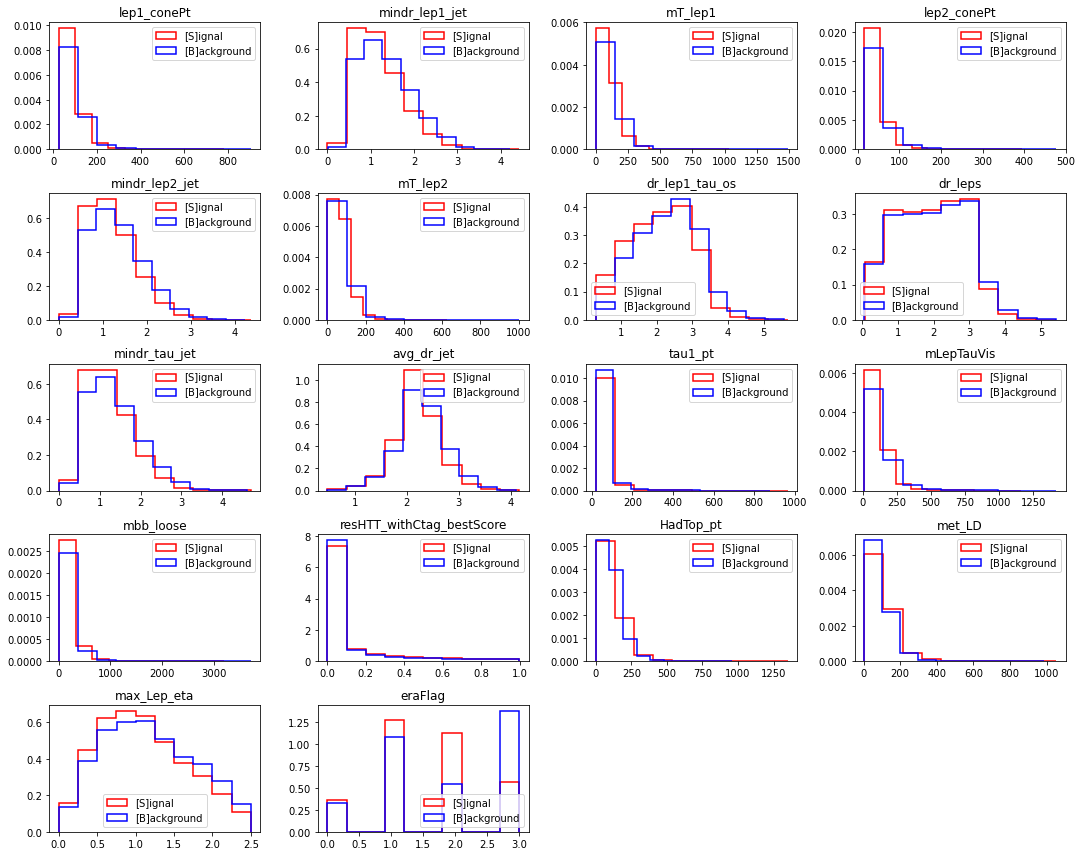

In [27]:
# 🔹 Signal (TTH) with red line
ax = data[target==1].hist(weights=None, figsize=(15,12), color='r', histtype='step', linewidth=1.5, density=True, label="[S]ignal")

ax = ax.flatten()[:data.shape[1]]

# 🔹 Background (TTZ) with blue line
data[target==0].hist(weights=None, color='b', histtype='step', linewidth=1.5, density=True, ax=ax, label="[B]ackground")

for a in ax:
    a.legend(loc="best")
    a.grid(False)

plt.tight_layout()

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/features_plots.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/features_plots.png", dpi=300)

plt.show()

In [28]:
'''
import seaborn as sn # seaborn for plots with more appealing defaults

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,9))
corrMatrix = data[target==1].corr()
sn.heatmap(corrMatrix, annot=True, ax=axes[0])
axes[0].set_title("Signal Feature Correlation Matrix",fontsize=18)

#print ("Background feature correlation matrix")
corrMatrix = data[target==0].corr()
sn.heatmap(corrMatrix, annot=True, ax=axes[1])
_ = axes[1].set_title("Background Feature Correlation Matrix",fontsize=18)
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()
'''

'\nimport seaborn as sn # seaborn for plots with more appealing defaults\n\nfig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,9))\ncorrMatrix = data[target==1].corr()\nsn.heatmap(corrMatrix, annot=True, ax=axes[0])\naxes[0].set_title("Signal Feature Correlation Matrix",fontsize=18)\n\n#print ("Background feature correlation matrix")\ncorrMatrix = data[target==0].corr()\nsn.heatmap(corrMatrix, annot=True, ax=axes[1])\n_ = axes[1].set_title("Background Feature Correlation Matrix",fontsize=18)\nplt.subplots_adjust(wspace=0.5)\nplt.tight_layout()\n\nplt.show()\n'

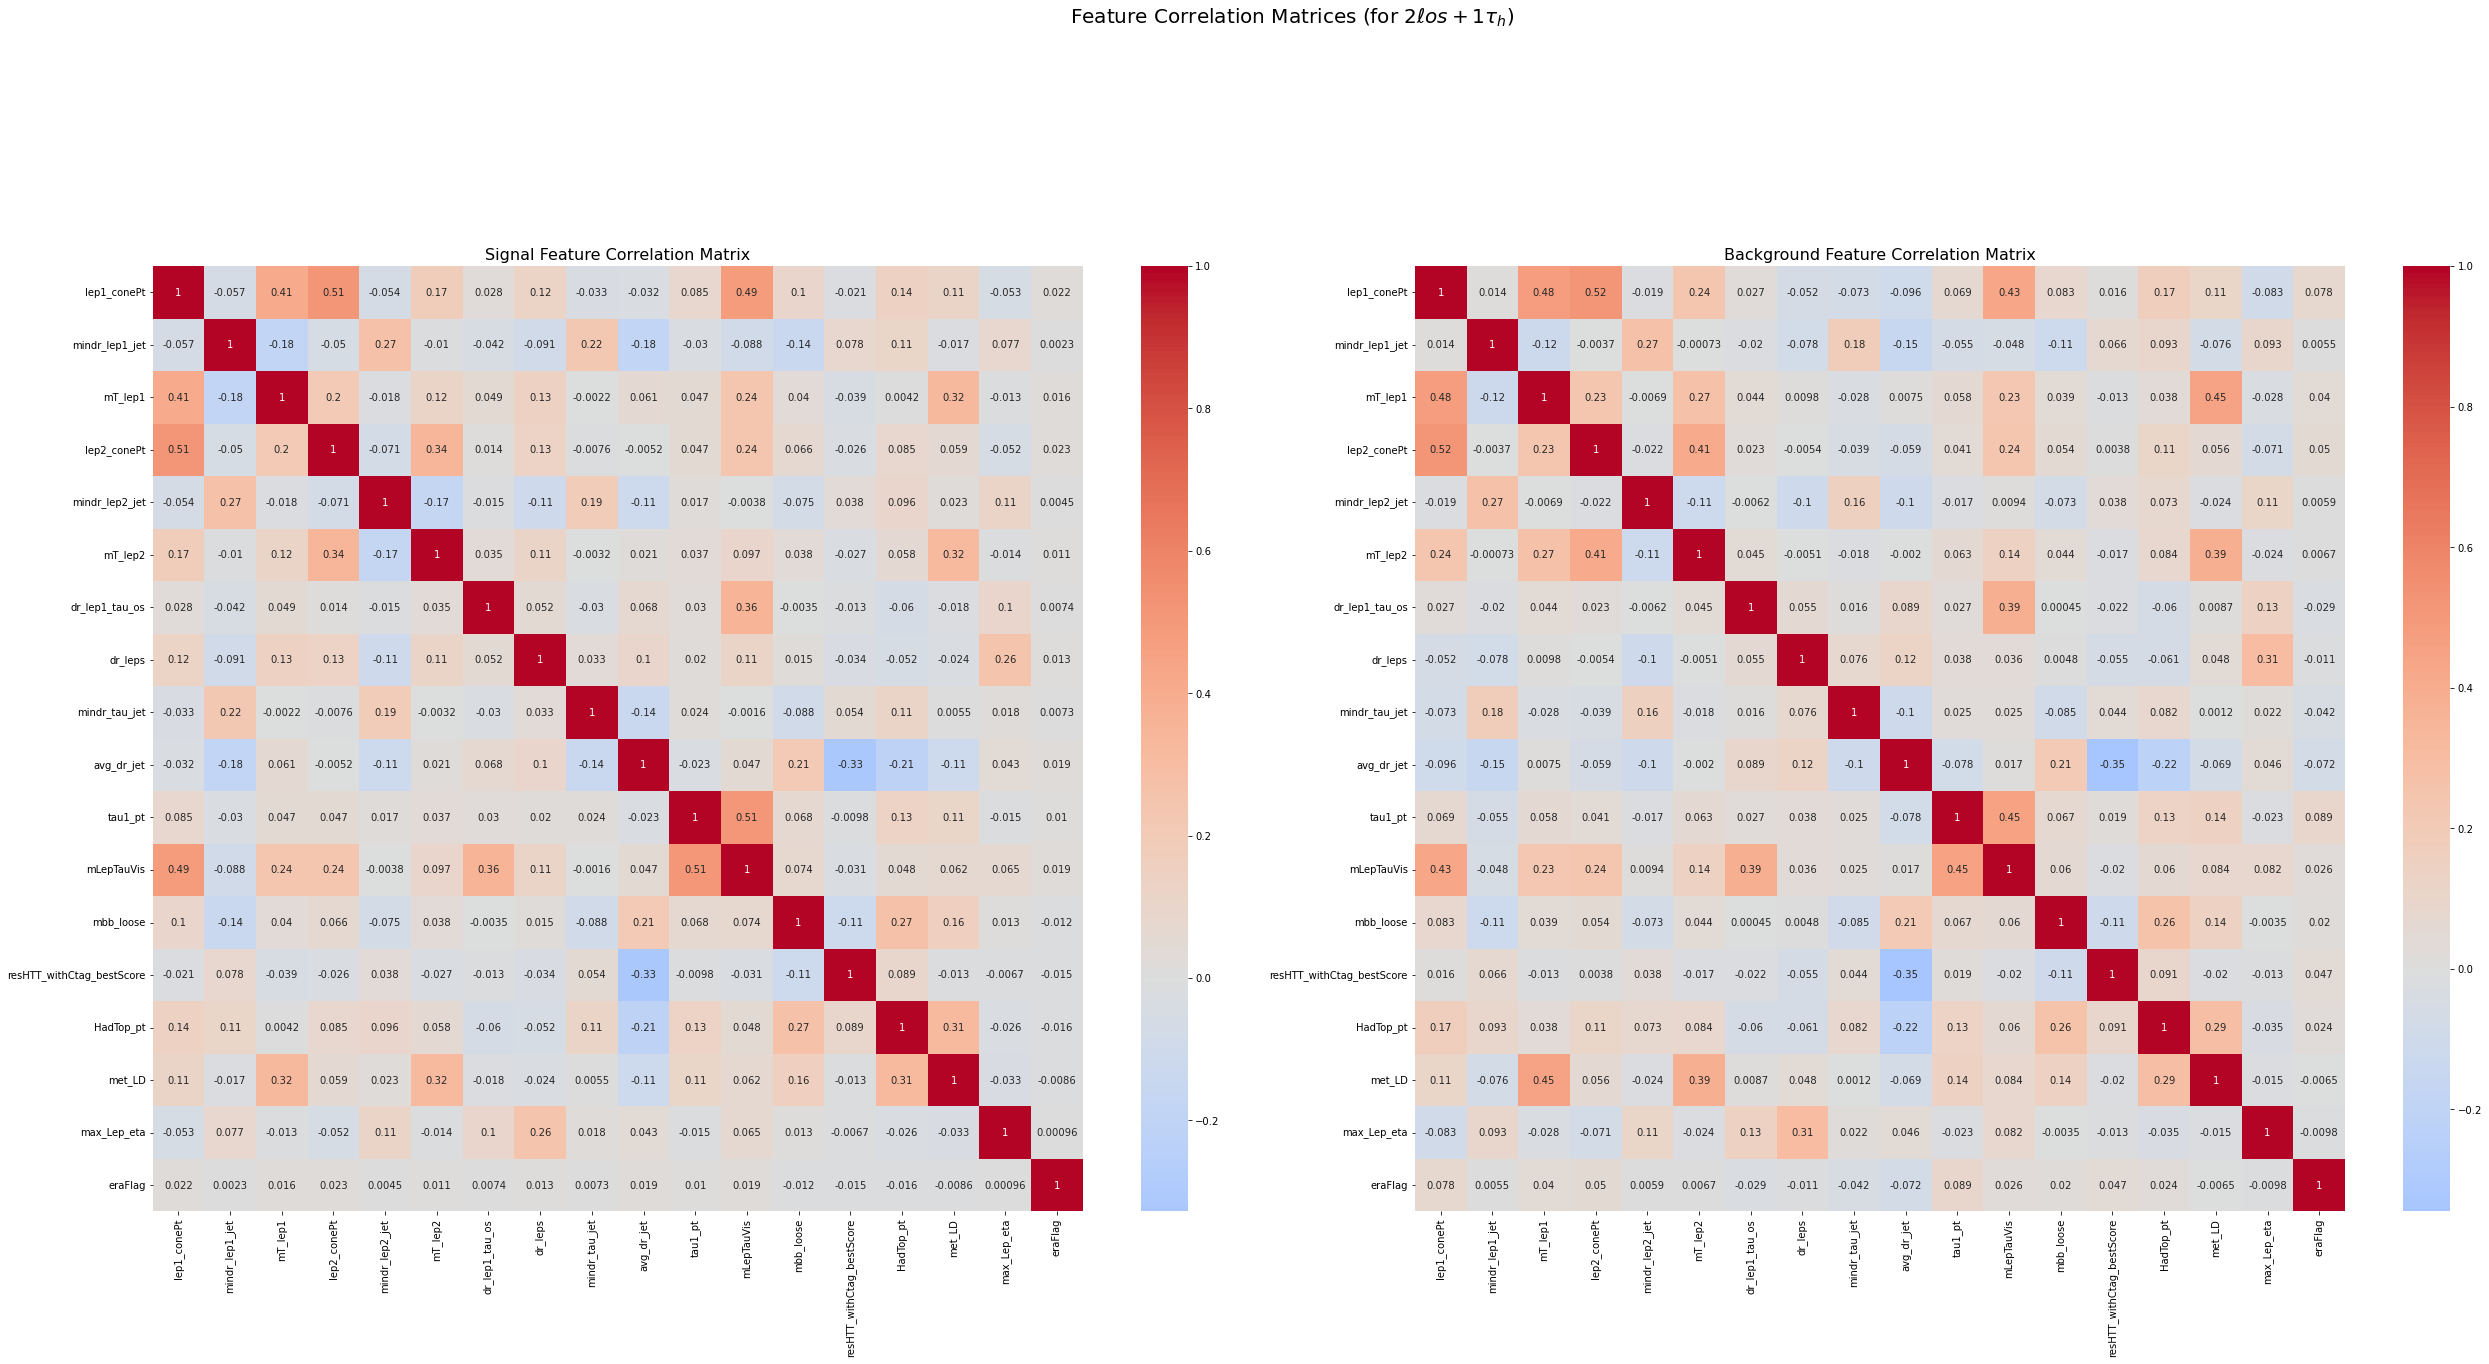

In [30]:
import seaborn as sn

#fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,8))
n_features = data.shape[1]
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(2*n_features, n_features))

corrMatrix = data[target==1].corr()
sn.heatmap(corrMatrix, annot=True, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Signal Feature Correlation Matrix", fontsize=16)

corrMatrix = data[target==0].corr()
sn.heatmap(corrMatrix, annot=True, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title(r"Background Feature Correlation Matrix", fontsize=16)

plt.tight_layout()  # pehle layout adjust karo
fig.suptitle(r"Feature Correlation Matrices (for $2\ell os + 1\tau_{h}$)", fontsize=20, y=1.05)  # fir suptitle lagao
plt.subplots_adjust(top=0.85)  # top space bacha lo

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/features_corrMatrix_plots.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/features_corrMatrix_plots.png", dpi=300)

plt.show()

# Preprocess Data

Split Data into Test and Training

In [35]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

display(data) 
#target = fulldata['label'].astype(int)
display(target)


# Train-test split (with stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, stratify=target, random_state=42
)

# Step 4: Handle class imbalance using scale_pos_weight
# Calculate scale_pos_weight = (negative class) / (positive class)
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos

neg, pos = np.bincount(y_train)
print(f"Background (0): {neg}, Signal (1): {pos}")
print(f"scale_pos_weight = {neg / pos:.2f}")

,lep1_conePt,mindr_lep1_jet,mT_lep1,lep2_conePt,mindr_lep2_jet,mT_lep2,dr_lep1_tau_os,dr_leps,mindr_tau_jet,avg_dr_jet,tau1_pt,mLepTauVis,mbb_loose,resHTT_withCtag_bestScore,HadTop_pt,met_LD,max_Lep_eta,eraFlag
0,44.944744,0.615411,65.430771,28.473541,0.859868,82.713127,0.862958,0.610257,1.162518,2.669390,54.717148,41.812832,573.914734,0.010040,42.231964,123.937665,0.466236,0
1,90.187737,1.130697,131.276260,17.443111,0.671168,15.582659,2.045738,2.180117,2.631557,1.906014,20.739439,84.843811,235.224442,0.224922,153.494370,103.007993,0.727905,0
2,62.853905,1.520506,81.100395,20.262230,0.587304,63.405384,2.736574,1.480690,0.947204,2.114031,26.400787,92.805542,166.928558,0.000140,134.496719,91.514969,2.040527,0
3,77.207527,0.750797,213.337189,46.238811,1.761078,134.464600,3.879208,1.329747,0.744140,1.921184,24.903727,155.924225,300.836884,0.696191,197.210007,113.134919,0.960205,0
4,67.754005,2.865362,6.995020,66.551888,2.283759,62.698711,1.503032,0.658198,2.110093,1.302196,40.326904,83.959213,316.723480,0.023184,248.695908,179.602989,2.312439,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64526,104.827629,1.271025,1.837488,89.998802,0.861954,28.408384,2.722080,1.275586,1.116995,2.244851,40.660648,156.493317,52.003853,0.317764,47.377296,24.934149,1.817154,3
64527,47.124405,0.658073,43.648224,27.091307,1.368818,5.225530,2.608470,0.931492,0.783790,2.279254,40.615959,102.825813,120.926453,0.309478,32.146355,39.161937,0.409973,3
64528,62.363956,1.094501,42.553795,18.137430,1.840065,55.366745,3.195479,2.996308,0.494161,2.257088,78.747772,209.917114,171.065277,0.001003,71.292442,77.604675,1.952789,3
64529,122.442551,0.942391,27.357861,51.006500,1.950048,36.901012,1.631235,2.194018,1.098159,1.227449,22.929617,104.903755,85.505859,0.557226,193.506363,44.549703,2.127441,3


0        1
1        1
2        1
3        1
4        1
        ..
64526    0
64527    0
64528    0
64529    0
64530    0
Name: label, Length: 154332, dtype: int64

Background (0): 51625, Signal (1): 71840
scale_pos_weight = 0.72


In [36]:
sum(y_train)/len(y_train)

0.5818653059571538

In [37]:
sum(y_test)/len(y_test)

0.5818835649723005

In [38]:
display(X_train)
display(X_test)
display(y_train)
display(y_test)
print ("X_train shape:",X_train.shape)
print ("y_train shape:",y_train.shape, "\n")

print ("X_test shape:",X_test.shape)
print ("y_test shape:",y_test.shape, "\n")

,lep1_conePt,mindr_lep1_jet,mT_lep1,lep2_conePt,mindr_lep2_jet,mT_lep2,dr_lep1_tau_os,dr_leps,mindr_tau_jet,avg_dr_jet,tau1_pt,mLepTauVis,mbb_loose,resHTT_withCtag_bestScore,HadTop_pt,met_LD,max_Lep_eta,eraFlag
31899,46.831825,1.019870,124.858131,40.740620,0.916134,112.100098,1.599771,0.464411,0.683649,3.295126,28.039215,62.597351,64.119102,0.000182,63.045334,82.081901,0.482372,1
57030,85.897247,2.360861,51.352737,18.933870,2.254017,63.201107,1.220522,2.039817,2.264991,1.723469,22.174400,51.119576,328.290375,0.881551,124.560242,57.197953,0.590576,2
28669,39.079288,2.130651,91.150665,18.478081,0.967979,86.364944,3.164889,2.176909,1.185010,3.321002,32.495922,68.084015,204.408722,0.000166,51.854095,75.852249,1.098145,1
15832,36.018711,1.467260,77.799965,20.978493,1.261771,57.180893,1.965844,1.086254,2.851807,2.327786,39.464478,58.583652,111.284981,0.012391,109.095352,52.521495,1.200439,1
3516,53.944168,0.739692,98.175186,15.386274,0.972786,45.586819,2.394526,1.176484,1.074207,2.234393,39.488182,85.997849,149.186600,0.311768,19.783846,42.285914,0.530273,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89254,35.655106,1.429201,92.304092,27.638065,2.570503,25.437874,1.834945,2.930337,1.012781,2.896955,40.072021,63.732403,120.901825,0.000134,36.892670,91.468820,0.984039,3
58263,159.269669,1.521056,89.124115,29.191349,0.729394,63.108841,1.257704,2.053807,1.160424,2.422069,50.639297,265.317627,306.520508,0.002463,154.960419,80.911227,0.755005,2
69585,75.994720,0.413721,24.206850,64.725937,0.704004,117.962708,1.744854,2.415821,1.050495,2.215494,25.318501,29.026306,417.593628,0.718652,103.729774,70.573494,0.957031,2
26521,68.679161,1.036547,18.647772,64.580002,1.061963,131.108337,2.273903,3.080353,2.570488,2.578148,20.147064,97.325691,155.165161,0.000224,84.313194,66.627824,0.509766,1


,lep1_conePt,mindr_lep1_jet,mT_lep1,lep2_conePt,mindr_lep2_jet,mT_lep2,dr_lep1_tau_os,dr_leps,mindr_tau_jet,avg_dr_jet,tau1_pt,mLepTauVis,mbb_loose,resHTT_withCtag_bestScore,HadTop_pt,met_LD,max_Lep_eta,eraFlag
67616,52.569023,0.687709,22.428724,44.671909,1.881136,6.719427,0.968297,1.993700,1.234037,2.226961,23.462523,34.194847,150.864532,0.002449,50.219109,36.259247,1.455170,2
63871,125.127426,1.439517,24.217121,58.780945,1.585387,66.194565,2.782459,3.025396,0.559339,2.845074,32.455544,57.985725,67.955750,0.596987,93.394127,33.470182,1.192627,3
66761,57.376511,0.730452,90.309410,25.724205,0.437707,86.215790,2.416713,1.079189,1.095660,2.407229,26.939102,78.659462,48.719559,0.079586,18.886774,83.509983,2.114502,2
25934,42.772781,0.533477,103.355988,25.028761,1.896487,24.018160,2.575913,3.344264,1.072605,3.248387,24.155552,78.180359,202.650818,0.000137,59.602135,87.704135,1.760040,1
21438,85.371483,1.752854,63.735031,57.395817,0.947984,84.433083,2.785976,3.508736,2.338855,2.037022,21.150808,130.128433,100.226807,0.069697,49.029598,70.659069,1.579346,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50258,37.299568,0.525625,118.925262,22.043119,2.821931,69.790367,1.893651,3.746290,1.140200,1.817355,32.105141,84.664268,210.602264,0.001466,161.862228,95.712063,2.191345,3
8181,92.775467,0.537058,42.150551,29.975561,0.633349,34.487614,1.785891,0.372962,1.449453,2.050859,42.961922,116.470955,81.012581,0.030105,41.980545,27.488985,0.971367,1
9597,26.315741,0.796620,123.131493,17.733234,0.612345,96.225563,2.669769,0.667190,0.958556,2.002845,43.765289,67.186813,114.170921,0.040463,113.054092,132.108657,0.387318,1
10267,74.481071,0.689861,25.491457,16.717539,1.239545,26.396185,2.795334,1.249474,0.637449,2.027039,23.748398,111.172966,118.519852,0.071563,26.154938,67.465829,0.087436,1


31899    1
57030    1
28669    1
15832    1
3516     1
        ..
89254    1
58263    1
69585    1
26521    0
82260    1
Name: label, Length: 123465, dtype: int64

67616    1
63871    0
66761    1
25934    0
21438    0
        ..
50258    0
8181     0
9597     0
10267    0
50315    1
Name: label, Length: 30867, dtype: int64

X_train shape: (123465, 18)
y_train shape: (123465,) 

X_test shape: (30867, 18)
y_test shape: (30867,) 



# Standardize the Data

Scale to Mean of 0 and Variance of 1.0: $ (x - \mu) / \sigma $

In [39]:
# not usually needed for BDT but is good practice
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test) #applies the transformation calculated the line above

In [40]:
#print("Means:", scaler.mean_)
#print("Scales:", scaler.scale_)

# Train BDT using XGBoost (Finally!)

In [41]:
do_model_training_Bydefualt_HP = True

In [42]:
if do_model_training_Bydefualt_HP:
    
    np.random.seed(31415) # set the random seed

    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report

    xgb = XGBClassifier()

    starting_time = time.time()

    xgb.fit(X_train, y_train.values, sample_weight=None)

    training_time = time.time( ) - starting_time
    print("Training time:",training_time)

    y_pred_xgb = xgb.predict_proba(X_test)[:,1]
    y_pred_xgb = y_pred_xgb.ravel()
    y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
    auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=None)
    print("auc test:",auc_test_xgb)
    print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,sample_weight=None),"\n")
    
    y_predict = xgb.predict(X_test)
    print(accuracy_score(y_test, y_predict))
    #print(classification_report(y_test, y_predict))
    
    #display(pd.crosstab(y_test, y_predict))
    
    #print("\n")
    #print("Difference between train and test value : ", abs(auc_test_xgb - roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_, sample_weight=None)))

Training time: 0.9935512542724609
auc test: 0.7391802264239151
auc train: 0.8293344892065769 

0.6887938575177374


In [43]:
if do_model_training_Bydefualt_HP:
    
    np.random.seed(31415) # set the random seed

    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0

    #xgb = XGBClassifier(tree_method="hist",eval_metric='logloss')
    xgb = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        #use_label_encoder=True,
        eval_metric='logloss',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    # tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
    # can even try tree_method="gpu_hist" if proper GPU installation

    # HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
    #xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100) 


    starting_time = time.time()

    xgb.fit(X_train, y_train.values, sample_weight=None)

    training_time = time.time( ) - starting_time
    print("Training time:",training_time)

    y_pred_xgb = xgb.predict_proba(X_test)[:,1]
    y_pred_xgb = y_pred_xgb.ravel()
    y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
    auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=None)
    print("auc test:",auc_test_xgb)
    print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,sample_weight=None),"\n")
    
    print("\n")
    print("Difference between train and test value : ", abs(auc_test_xgb - roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb, sample_weight=None)))

Training time: 0.7003834247589111
auc test: 0.7455327085607499
auc train: 0.7851260109902555 



Difference between train and test value :  0.03959330242950554


In [44]:
# Ye acha hai keep it 
if do_model_training_Bydefualt_HP:
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    xgb_ = XGBClassifier(
        objective='binary:logistic',
        #scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        max_depth = 3,
        subsample = 0.1, # not effecting for any range so keep the defalut = 1
        #n_etsimators = 100,
        learning_rate = 0.3,
        min_child_weight = 500, # till 10000 seems not effecting for my case
        #random_state = 90, # if changing this, test and train accuracy are also changing means model is not good
        reg_alpha = 0,
        reg_lambda = 0,
        #gamma = 6,
        tree_method = "hist",
    )
    starting_time = time.time()
    xgb_.fit(X_train, y_train.values)
    training_time = time.time( ) - starting_time
    print("Training time:",training_time)
    #y_predict = xgb_.predict(X_test)
    #y_train_predict = xgb_.predict(X_train)
    #print("Train accuracy :", accuracy_score(y_train, y_train_predict))
    #print("Train accuracy :", accuracy_score(y_test, y_predict))
    #print(classification_report(y_test, y_predict))
    #display(pd.crosstab(y_test, y_predict))
    y_pred_xgb_ = xgb_.predict_proba(X_test)[:,1]
    y_pred_xgb_ = y_pred_xgb_.ravel()
    y_pred_train_xgb_ = xgb_.predict_proba(X_train)[:,1].ravel()
    auc_test_xgb_ = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_,sample_weight=None)
    print("auc test_:",auc_test_xgb_)
    print ("auc train_:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_, sample_weight=None),"\n")
    
    print("\n")
    print("Difference between train and test value : ", abs(auc_test_xgb_ - roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_, sample_weight=None)))

Training time: 0.4242582321166992
auc test_: 0.7279994182688281
auc train_: 0.7347224371349838 



Difference between train and test value :  0.006723018866155672


In [45]:
'''
if do_model_training_Bydefualt_HP:
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    xgb_ = XGBClassifier(
        objective='binary:logistic',
        #scale_pos_weight=scale_pos_weight,
        #eval_metric='logloss',
        eval_metric='auc',
        max_depth = 3,
        subsample = 1.0,
        colsample_bytree = 0.8,
        #n_etsimators = 200,
        learning_rate = 0.1,
        min_child_weight = 300,
        reg_alpha = 0,
        reg_lambda = 0,
        #gamma = 6,
        #tree_method = "hist",
    )
    starting_time = time.time()
    xgb_.fit(X_train, y_train.values)
    training_time = time.time( ) - starting_time
    print("Training time:",training_time)
    #y_predict = xgb_.predict(X_test)
    #y_train_predict = xgb_.predict(X_train)
    #print("Train accuracy :", accuracy_score(y_train, y_train_predict))
    #print("Train accuracy :", accuracy_score(y_test, y_predict))
    #print(classification_report(y_test, y_predict))
    #display(pd.crosstab(y_test, y_predict))
    y_pred_xgb_ = xgb_.predict_proba(X_test)[:,1]
    y_pred_xgb_ = y_pred_xgb_.ravel()
    y_pred_train_xgb_ = xgb_.predict_proba(X_train)[:,1].ravel()
    auc_test_xgb_ = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_,sample_weight=None)
    print("auc test_:",auc_test_xgb_)
    print ("auc train_:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_, sample_weight=None),"\n")
    print("\n")
    print("Difference between train and test value : ", abs(auc_test_xgb_ - roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_, sample_weight=None)))
'''

'\nif do_model_training_Bydefualt_HP:\n    from xgboost import XGBClassifier\n    from sklearn.metrics import roc_auc_score\n    from sklearn.metrics import accuracy_score\n    from sklearn.metrics import classification_report\n    xgb_ = XGBClassifier(\n        objective=\'binary:logistic\',\n        #scale_pos_weight=scale_pos_weight,\n        #eval_metric=\'logloss\',\n        eval_metric=\'auc\',\n        max_depth = 3,\n        subsample = 1.0,\n        colsample_bytree = 0.8,\n        #n_etsimators = 200,\n        learning_rate = 0.1,\n        min_child_weight = 300,\n        reg_alpha = 0,\n        reg_lambda = 0,\n        #gamma = 6,\n        #tree_method = "hist",\n    )\n    starting_time = time.time()\n    xgb_.fit(X_train, y_train.values)\n    training_time = time.time( ) - starting_time\n    print("Training time:",training_time)\n    #y_predict = xgb_.predict(X_test)\n    #y_train_predict = xgb_.predict(X_train)\n    #print("Train accuracy :", accuracy_score(y_train, y_tra

# SAVING MODEL

In [46]:
#import os
#import joblib
#import pickle

#save_dir = "models"
#os.makedirs(save_dir, exist_ok=True)
#save_path = os.path.join(save_dir, "model_xgboost_forHjjTagger-2025-07-21.joblib")
#joblib.dump(xgb_, save_path)

# Also, Save the model using pickle
#with open("models/model_xgboost_forHjjTagger-2025-07-21.pkl", "wb") as f:
    #pickle.dump(xgb_, f)

In [47]:
def compare_train_test(
    y_pred_train, y_train, y_pred, y_test, high_low=(0, 1),
    bins=20, xlabel="", ylabel="Arbitrary units", title="",
    weights_train=None, weights_test=None, density=True):
    
    # Handle weights for training data
    if weights_train is not None:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    
    # Plot training data for signal and background
    plt.hist(y_pred_train[y_train == 1],
             color='r', alpha=0.5, range=high_low, bins=bins,
             histtype='stepfilled', density=density,
             label='S (train)', weights=weights_train_signal)
    
    plt.hist(y_pred_train[y_train == 0],
             color='b', alpha=0.5, range=high_low, bins=bins,
             histtype='stepfilled', density=density,
             label='B (train)', weights=weights_train_background)
    
    # Handle weights for testing data
    if weights_test is not None:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None

    # Plot test signal with error bars
    hist, bins = np.histogram(y_pred[y_test == 1],
                              bins=bins, range=high_low, density=density,
                              weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / np.sum(hist) if np.sum(hist) != 0 else 0
    err = np.sqrt(hist * scale) / scale if scale != 0 else np.zeros_like(hist)
    
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    # Plot test background with error bars
    hist, bins = np.histogram(y_pred[y_test == 0],
                              bins=bins, range=high_low, density=density,
                              weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / np.sum(hist) if np.sum(hist) != 0 else 0
    err = np.sqrt(hist * scale) / scale if scale != 0 else np.zeros_like(hist)
    
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    
    # ---- Add KS test here ----
    from scipy.stats import ks_2samp

    # KS test for signal
    ks_signal = ks_2samp(y_pred_train[y_train == 1], y_pred[y_test == 1])
    # KS test for background
    ks_background = ks_2samp(y_pred_train[y_train == 0], y_pred[y_test == 0])
    
    # Create a string with KS test results
    ks_text = f"KS test p-value(S): {ks_signal.pvalue:.3f}\nKS test p-value(B): {ks_background.pvalue:.3f}"
    # Display the KS results on the plot
    #plt.text(0.2, 0.95, ks_text, transform=plt.gca().transAxes,
    #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    #plt.text(0.05, 0.95, ks_text, transform=plt.gca().transAxes,
             #verticalalignment='top', horizontalalignment='left',
             #bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.01, 0.99, ks_text, transform=plt.gca().transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # ---------------------------
    
    # Final plot formatting
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')

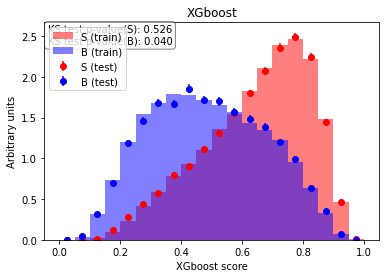

In [48]:
compare_train_test(y_pred_train_xgb_, y_train, y_pred_xgb_, y_test, xlabel="XGboost score", title="XGboost", weights_train=None, weights_test=None, density=True)
plt.show()

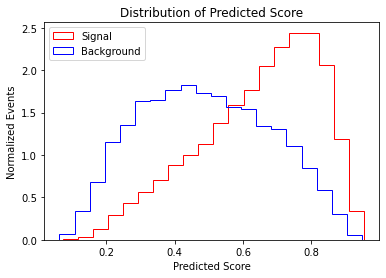

In [49]:
# Get discriminator score
#scores = loaded_model.predict_proba(X_test)[:, 1]
scores = y_pred_xgb_
# Plot signal vs background score distribution
#plt.hist(scores[y_test==1], bins=20, alpha=0.6, histtype='step', label='Signal', density=True)
#plt.hist(scores[y_test==0], bins=20, alpha=0.6, histtype='step', label='Background', density=True)
plt.hist(scores[y_test==1], bins=20, color='r', histtype='step', label='Signal', density=True)
plt.hist(scores[y_test==0], bins=20, color='b', histtype='step', label='Background', density=True)
plt.xlabel("Predicted Score")
plt.ylabel("Normalized Events")
plt.legend()
#plt.grid(True)
plt.title("Distribution of Predicted Score")
plt.show()

In [50]:
X_train.columns

Index(['lep1_conePt', 'mindr_lep1_jet', 'mT_lep1', 'lep2_conePt',
       'mindr_lep2_jet', 'mT_lep2', 'dr_lep1_tau_os', 'dr_leps',
       'mindr_tau_jet', 'avg_dr_jet', 'tau1_pt', 'mLepTauVis', 'mbb_loose',
       'resHTT_withCtag_bestScore', 'HadTop_pt', 'met_LD', 'max_Lep_eta',
       'eraFlag'],
      dtype='object')

In [51]:
X_test.columns

Index(['lep1_conePt', 'mindr_lep1_jet', 'mT_lep1', 'lep2_conePt',
       'mindr_lep2_jet', 'mT_lep2', 'dr_lep1_tau_os', 'dr_leps',
       'mindr_tau_jet', 'avg_dr_jet', 'tau1_pt', 'mLepTauVis', 'mbb_loose',
       'resHTT_withCtag_bestScore', 'HadTop_pt', 'met_LD', 'max_Lep_eta',
       'eraFlag'],
      dtype='object')

array([       inf, 0.953422  , 0.95128447, ..., 0.07613667, 0.07335748,
       0.06242991], dtype=float32)

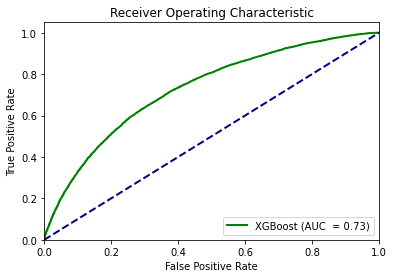

In [52]:
from sklearn.metrics import roc_curve
fpr_xgb_, tpr_xgb_, threshold = roc_curve(y_true=y_test, y_score=y_pred_xgb_, sample_weight=None)
plt.plot(fpr_xgb_, tpr_xgb_, color='green',lw=2, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb_,decimals=2)))
display(threshold)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate

# Significance Function

In [53]:
from math import sqrt
from math import log
def amsasimov(s,b):
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

In [54]:
int_pred_test_sig_xgb_ = [((y_test ==1) & (y_pred_xgb_ > th_cut)).sum() for th_cut in threshold]
int_pred_test_bkg_xgb_ = [((y_test ==0) & (y_pred_xgb_ > th_cut)).sum() for th_cut in threshold]

vamsasimov_xgb_ = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb_, int_pred_test_bkg_xgb_)]
significance_xgb_ = max(vamsasimov_xgb_) #finds the maximum significance. Which threshold results in this significance?
Z_ = significance_xgb_
print("Z:",Z_)

Z: 143.02727998129637


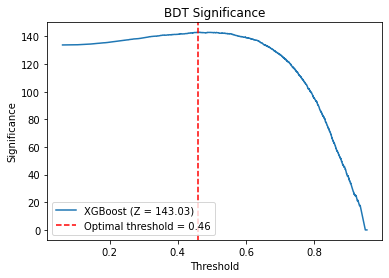

In [55]:
plt.plot(threshold, vamsasimov_xgb_, label='XGBoost (Z = {})'.format(np.round(significance_xgb_, decimals=2)))

idx_max = np.argmax(vamsasimov_xgb_)
opt_th = threshold[idx_max]

plt.axvline(opt_th, color='r', linestyle='--', label=f'Optimal threshold = {np.round(float(opt_th), 2)}')

plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.show()

# XGBoost Feature Importance

Feature importance allows to display the importance of each feature without rerunnning the training. It is obtained from internal algorithm quantities, like number of time a feature is used to define leaf, and the information gained from the nodes that use that feature. Magnitude is arbitrary. It not always a reliable indication of which feature is the most discriminant.

[0.03973094 0.06827924 0.03333867 0.03607349 0.04794134 0.03166994
 0.04748032 0.03394586 0.04515097 0.07412009 0.05202878 0.05640972
 0.02601287 0.02404534 0.02198102 0.0543003  0.03609566 0.27139547]


,index,features,importance
0,17,eraFlag,0.271395
1,9,avg_dr_jet,0.074120
2,1,mindr_lep1_jet,0.068279
3,11,mLepTauVis,0.056410
4,15,met_LD,0.054300
5,10,tau1_pt,0.052029
6,4,mindr_lep2_jet,0.047941
7,6,dr_lep1_tau_os,0.047480
8,8,mindr_tau_jet,0.045151
9,0,lep1_conePt,0.039731


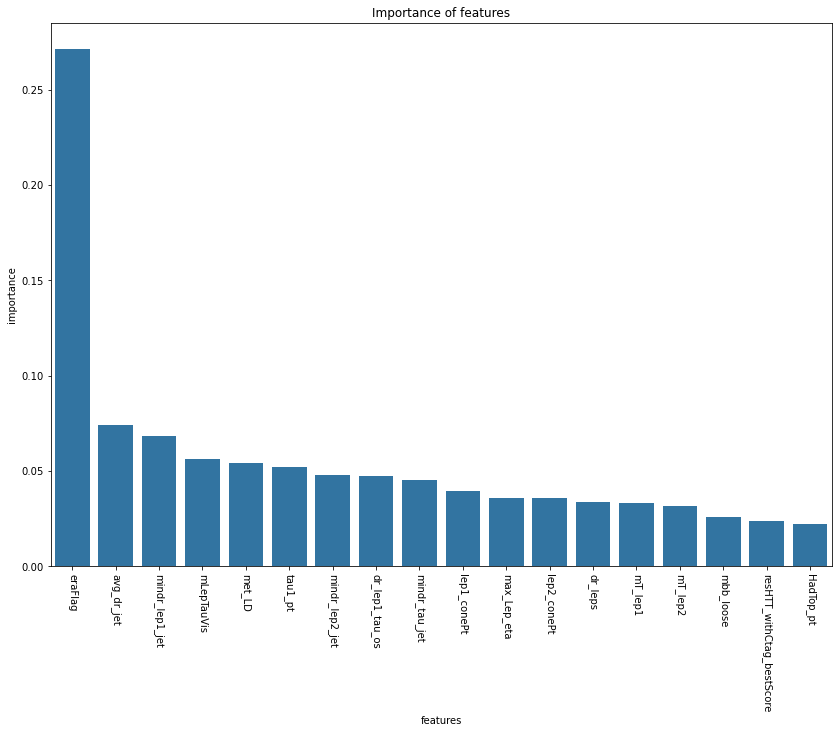

In [56]:
importances = xgb_.feature_importances_
print(importances)
df_importance = pd.DataFrame( {"features": data.columns.values, "importance": importances} )
df_importance = df_importance.sort_values('importance', ascending=False).reset_index()
display(df_importance)

# Dynamic figure size based on feature count
num_features = len(df_importance)
fig_width = max(14, num_features * 0.5) 
fig_hight = 10
plt.figure(figsize=(fig_width, fig_hight))

sn.barplot(data = df_importance, x = 'features', y = 'importance')
plt.xticks(rotation=270)
plt.title("Importance of features")
plt.show()

# Hyper Parameter Optimisation

In [57]:
do_HP_optimization = False

In [58]:
round_1 = True
#round_1 = False
if round_1:
    '''
    param_grid_r1 = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.05],
        'gamma':  [0, 0.25, 1.0],
        'reg_lambda': [0, 1.0, 10.0],
    }
    '''
    '''
    param_grid_r1 = {
        "max_depth": [3, 4, 5, 6],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "n_estimators": [100, 200, 500],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "min_child_weight": [1, 5, 10],
        "reg_alpha": [0, 0.5, 1],
        "reg_lambda": [1, 5, 10],
    }
    '''
    param_grid_r1 = {
        "max_depth": [2, 3, 4],
        "learning_rate": [0.1, 0.2, 0.3, 0.4],
        "subsample": [0.0, 0.1, 0.2],
        "min_child_weight": [400, 500, 600],
        "reg_alpha": [0, 1],
        "reg_lambda": [0, 1],
    }

In [59]:
import site
import sys
sys.path.append(site.getusersitepackages())

In [70]:
if round_1:
    import time
    import os
    import joblib
    
    #import onnxmltools
    #from xgboost import XGBClassifier
    #from skl2onnx import convert_sklearn
    #from skl2onnx.common.data_types import FloatTensorType
    #from onnxmltools.convert.common.data_types import FloatTensorType
    
    from datetime import timedelta
    from sklearn.model_selection import GridSearchCV
    optimal_params_r1 = GridSearchCV(
        #estimator= XGBClassifier(objective='binary:logistic', eval_metric='auc', seed=42, early_stopping_rounds=10, subsample=0.9, colsample_bytree=0.5),
        #estimator= XGBClassifier(objective='binary:logistic', eval_metric=["auc", "logloss", "error"], seed=42, early_stopping_rounds=10, subsample=0.9, colsample_bytree=0.5),
        #estimator= XGBClassifier(objective='binary:logistic', eval_metric='auc', seed=42, early_stopping_rounds=10, subsample=0.9),
        # 1. 
        #estimator= XGBClassifier(objective='binary:logistic', eval_metric='auc', seed=42, early_stopping_rounds=17, subsample=0.3), # this is also good
        #2.
        #estimator= XGBClassifier(objective='binary:logistic', eval_metric=["auc", "logloss", "error"], seed=42, early_stopping_rounds=20, subsample=0.3), # this is also good
        # keep in the slide for both  result to show (above two only)
        estimator = XGBClassifier(objective="binary:logistic", tree_method="hist", eval_metric="logloss"),
        param_grid=param_grid_r1,
        scoring='roc_auc',
        verbose=4,
        n_jobs=10,
        cv=3
    )

    starting_time = time.time()
    optimal_params_r1.fit(X_train,
                      y_train,
                      #eval_set=[(X_test, y_test)],
                      #eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=True)

    best_model = optimal_params_r1.best_estimator_
    save_dir = "2los1tau"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "model_xgboost_forSignalExtractionWithBDT_for_2los1tau_21Aug2025_NoWeight.joblib")
    joblib.dump(best_model, save_path)

    training_time = time.time() - starting_time
    print("Training time:", timedelta(seconds=training_time))
    print("✅ Model training complete! Ready for evaluation.")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.726 total time=   3.5s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.726 total time=   2.0s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.726 total time=   2.1s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.724 total time=   2.1s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.721 total time=   2.1s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.723 total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda

[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   3.2s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.7s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.730 total time=   2.3s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.7s
[CV 3/3] END 

[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   3.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.725 total time=   2.1s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.725 total time=   2.2s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.726 total time=   2.3s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.726 total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.7s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.725 total time=   2.2s
[CV 2/3] END 

[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.731 total time=   3.7s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.734 total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.7s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.728 total time=   2.2s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.7s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.726 total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.7s
[CV 1/3] END 

[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.731 total time=   3.7s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.729 total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.2;, score=0.731 total time=   2.2s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.733 total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.722 total time=   2.3s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.723 total time=   2.2s
[CV 3/3] END 

[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.729 total time=   3.7s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.731 total time=   2.2s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.2;, score=0.734 total time=   2.3s
[CV 3/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.7s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.8s
[CV 1/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.730 total time=   2.3s
[CV 2/3] END learning_rate=0.1, max_depth=2, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.7s
[CV 2/3] END 

[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.2;, score=0.735 total time=   2.8s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.7s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.739 total time=   2.8s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.723 total time=   2.3s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.659 total time=   2.2s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.661 total time=   2.1s
[CV 1/3] END 

[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.723 total time=   2.3s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.724 total time=   2.3s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.725 total time=   2.3s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.728 total time=   2.2s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.732 total time=   2.5s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=0, subsample=0.2;, score=0.734 total time=   2.6s
[CV 3/3] END 

[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.734 total time=   2.7s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.7s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.2;, score=0.734 total time=   2.8s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 2/3] END 

[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.728 total time=   2.3s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.2;, score=0.738 total time=   2.7s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.655 total time=   2.2s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.658 total time=   2.2s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.661 total time=   2.3s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=1, subsample=0.2;, score=0.732 total time=   2.6s
[CV 2/3] END learning_rate=0.3, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 1/3] END 

[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=500, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.725 total time=   2.4s
[CV 3/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.660 total time=   2.3s
[CV 2/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.733 total time=   2.6s
[CV 1/3] END learning_rate=0.2, max_depth=4, min_child_weight=600, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.655 total time=   2.2s
[CV 1/3] END learning_rate=0.3, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.727 total time=   2.1s
[CV 2/3] END learning_rate=0.3, max_depth=2, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.1;, score=0.727 total time=   2.1s
[CV 3/3] END learning_rate=0.3, max_depth=2, min_child_weight=400, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.731 total time=   2.1s
[CV 2/3] END 

In [71]:
if round_1:
    print(optimal_params_r1.best_params_)

{'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 400, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.2}


In [72]:
#evals_result = optimal_params_r1.best_estimator_.evals_result()
#print(evals_result)

In [73]:
'''
results = evals_result
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

import matplotlib.pyplot as plt
plt.plot(x_axis, results['validation_0']['auc'], label='Test AUC')
plt.plot(x_axis, results['validation_1']['auc'], label='Train AUC')
plt.xlabel("Boosting Rounds")
plt.ylabel("AUC Score")
plt.legend()

#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/xgb_auc.png.pdf", dpi=300)
#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/xgb_auc.png.png", dpi=300)

plt.show()
'''

'\nresults = evals_result\nepochs = len(results[\'validation_0\'][\'auc\'])\nx_axis = range(0, epochs)\n\nimport matplotlib.pyplot as plt\nplt.plot(x_axis, results[\'validation_0\'][\'auc\'], label=\'Test AUC\')\nplt.plot(x_axis, results[\'validation_1\'][\'auc\'], label=\'Train AUC\')\nplt.xlabel("Boosting Rounds")\nplt.ylabel("AUC Score")\nplt.legend()\n\n#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/xgb_auc.png.pdf", dpi=300)\n#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/xgb_auc.png.png", dpi=300)\n\nplt.show()\n'

In [74]:
'''
import matplotlib.pyplot as plt

results = optimal_params_r1.best_estimator_.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# AUC
axes[0].plot(x_axis, results['validation_0']['auc'], label='Train AUC')
axes[0].plot(x_axis, results['validation_1']['auc'], label='Validation AUC')
axes[0].set_title('XGBoost AUC')
axes[0].set_xlabel('Boosting Round')
axes[0].set_ylabel('AUC')
axes[0].legend()
axes[0].grid(True)

# Logloss
axes[1].plot(x_axis, results['validation_0']['logloss'], label='Train Logloss')
axes[1].plot(x_axis, results['validation_1']['logloss'], label='Validation Logloss')
axes[1].set_title('XGBoost Logloss')
axes[1].set_xlabel('Boosting Round')
axes[1].set_ylabel('Logloss')
axes[1].legend()
axes[1].grid(True)

# Error
axes[2].plot(x_axis, results['validation_0']['error'], label='Train Error')
axes[2].plot(x_axis, results['validation_1']['error'], label='Validation Error')
axes[2].set_title('XGBoost Classification Error')
axes[2].set_xlabel('Boosting Round')
axes[2].set_ylabel('Error')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/xgb_auc_logloss_error.png.pdf", dpi=300)
#plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/xgb_auc_logloss_error.png.png", dpi=300)

plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\nresults = optimal_params_r1.best_estimator_.evals_result()\nepochs = len(results[\'validation_0\'][\'auc\'])\nx_axis = range(0, epochs)\n\nfig, axes = plt.subplots(1, 3, figsize=(18, 5))\n\n# AUC\naxes[0].plot(x_axis, results[\'validation_0\'][\'auc\'], label=\'Train AUC\')\naxes[0].plot(x_axis, results[\'validation_1\'][\'auc\'], label=\'Validation AUC\')\naxes[0].set_title(\'XGBoost AUC\')\naxes[0].set_xlabel(\'Boosting Round\')\naxes[0].set_ylabel(\'AUC\')\naxes[0].legend()\naxes[0].grid(True)\n\n# Logloss\naxes[1].plot(x_axis, results[\'validation_0\'][\'logloss\'], label=\'Train Logloss\')\naxes[1].plot(x_axis, results[\'validation_1\'][\'logloss\'], label=\'Validation Logloss\')\naxes[1].set_title(\'XGBoost Logloss\')\naxes[1].set_xlabel(\'Boosting Round\')\naxes[1].set_ylabel(\'Logloss\')\naxes[1].legend()\naxes[1].grid(True)\n\n# Error\naxes[2].plot(x_axis, results[\'validation_0\'][\'error\'], label=\'Train Error\')\naxes[2].plot(x_axis, r

In [75]:
#print("Best iteration:", optimal_params_r1.best_estimator_.best_iteration)
print("Best score:", optimal_params_r1.best_score_)

Best score: 0.7374526803267528


In [76]:
if round_1:
    y_pred_xgb_r1 = optimal_params_r1.predict_proba(X_test)[:,1]
    y_pred_xgb_r1 = y_pred_xgb_r1.ravel()
    y_pred_train_xgb_r1 = optimal_params_r1.predict_proba(X_train)[:,1].ravel()
    auc_test_xgb_r1 = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_r1, sample_weight=None)
    print("auc test_:",auc_test_xgb_r1)
    print ("auc train_:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_r1, sample_weight=None),"\n")
    
    print("")

auc test_: 0.7370419303811598
auc train_: 0.7459415928320671 




auc test_: 0.7370419303811598
auc train_: 0.7459415928320671 



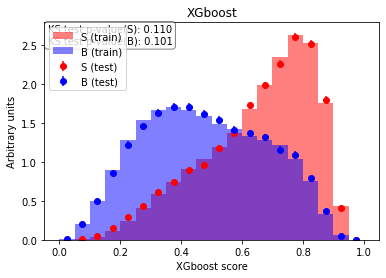

In [77]:
if round_1:
    y_pred_r1 = optimal_params_r1.predict_proba(X_test)[:,1]
    y_pred_r1 = y_pred_r1.ravel()
    y_pred_train_r1 = optimal_params_r1.predict_proba(X_train)[:,1].ravel()
    auc_test_r1 = roc_auc_score(y_true=y_test, y_score=y_pred_r1, sample_weight=None)
    print("auc test_:",auc_test_r1)
    print ("auc train_:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_r1, sample_weight=None),"\n")

    compare_train_test(y_pred_train_r1, y_train, y_pred_r1, y_test, xlabel="XGboost score", title="XGboost", weights_train=None, weights_test=None)
    
    plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/compare_train_test_plot.pdf", dpi=300)
    plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/compare_train_test_plot.png", dpi=300)
    
    plt.show()

In [78]:
import numpy as np
import joblib   # ya pickle

# --- TRAINED MODEL SE ---
# Assume y_train had signal=1, background=0
y_pred_before = optimal_params_r1.predict_proba(X_test)[:, 1]   # probability for class 1 (signal)

# --- SAVE MODEL ---
#joblib.dump(model, "xgb_model.pkl")

# --- LOAD MODEL ---
loaded_model = joblib.load("2los1tau/model_xgboost_forSignalExtractionWithBDT_for_2los1tau_21Aug2025_NoWeight.joblib")

# --- PREDICT AGAIN ---
y_pred_after = loaded_model.predict_proba(X_test)[:, 1]

# --- COMPARE ---
print("Mean score before save/load (signal events):", np.mean(y_pred_before[y_test==1]))
print("Mean score before save/load (background events):", np.mean(y_pred_before[y_test==0]))
print("Mean score after save/load (signal events):", np.mean(y_pred_after[y_test==1]))
print("Mean score after save/load (background events):", np.mean(y_pred_after[y_test==0]))

# --- Check if flipped or identical ---
corr = np.corrcoef(y_pred_before, y_pred_after)[0,1]
print("Correlation between before/after:", corr)

if np.allclose(y_pred_before, y_pred_after):
    print("✅ Predictions match exactly before and after save/load.")
elif np.allclose(y_pred_before, 1 - y_pred_after):
    print("⚠️ Predictions flipped! (probability of class 0 vs class 1 swapped)")
else:
    print("❌ Something else is wrong (likely preprocessing mismatch or version issue).")


Mean score before save/load (signal events): 0.6521682
Mean score before save/load (background events): 0.48168752
Mean score after save/load (signal events): 0.6521682
Mean score after save/load (background events): 0.48168752
Correlation between before/after: 1.0
✅ Predictions match exactly before and after save/load.


In [82]:
#y_pred = loaded_model.predict_proba(X_test)[:, 1]
#y_pred

array([0.77328944, 0.26293284, 0.82083243, ..., 0.84374356, 0.73770434,
       0.65687186], dtype=float32)

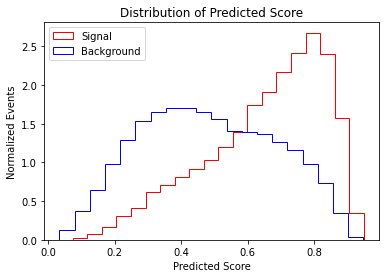

[CV 2/3] END learning_rate=0.4, max_depth=3, min_child_weight=600, reg_alpha=1, reg_lambda=0, subsample=0.2;, score=0.731 total time=   2.5s
[CV 3/3] END learning_rate=0.4, max_depth=4, min_child_weight=400, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 2/3] END learning_rate=0.4, max_depth=4, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.0;, score=0.500 total time=   1.6s
[CV 3/3] END learning_rate=0.4, max_depth=4, min_child_weight=400, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.735 total time=   3.4s
[CV 1/3] END learning_rate=0.4, max_depth=4, min_child_weight=400, reg_alpha=1, reg_lambda=1, subsample=0.1;, score=0.726 total time=   2.5s
[CV 3/3] END learning_rate=0.4, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.1;, score=0.727 total time=   2.2s
[CV 1/3] END learning_rate=0.4, max_depth=4, min_child_weight=500, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=0.731 total time=   3.1s
[CV 1/3] END 

[CV 1/3] END learning_rate=0.4, max_depth=3, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.6s
[CV 2/3] END learning_rate=0.4, max_depth=3, min_child_weight=500, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.732 total time=   2.5s
[CV 2/3] END learning_rate=0.4, max_depth=3, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.5s
[CV 2/3] END learning_rate=0.4, max_depth=3, min_child_weight=500, reg_alpha=1, reg_lambda=0, subsample=0.2;, score=0.733 total time=   2.5s
[CV 2/3] END learning_rate=0.4, max_depth=3, min_child_weight=600, reg_alpha=0, reg_lambda=0, subsample=0.0;, score=0.500 total time=   1.9s
[CV 3/3] END learning_rate=0.4, max_depth=3, min_child_weight=600, reg_alpha=0, reg_lambda=0, subsample=0.2;, score=0.735 total time=   4.8s
[CV 1/3] END learning_rate=0.4, max_depth=3, min_child_weight=600, reg_alpha=1, reg_lambda=0, subsample=0.1;, score=0.654 total time=   2.8s
[CV 3/3] END 

In [83]:
# Get discriminator score
scores = loaded_model.predict_proba(X_test)[:, 1]
#scores = y_pred_xgb_
# Plot signal vs background score distribution
#plt.hist(scores[y_test==1], bins=20, alpha=0.6, histtype='step', label='Signal', density=True)
#plt.hist(scores[y_test==0], bins=20, alpha=0.6, histtype='step', label='Background', density=True)
plt.hist(scores[y_test==1], bins=20, color='r', histtype='step', label='Signal', density=True)
plt.hist(scores[y_test==0], bins=20, color='b', histtype='step', label='Background', density=True)
plt.xlabel("Predicted Score")
plt.ylabel("Normalized Events")
plt.legend()
#plt.grid(True)
plt.title("Distribution of Predicted Score")
plt.show()

Signal correctly classified: 79.23%
Background correctly classified: 54.56%


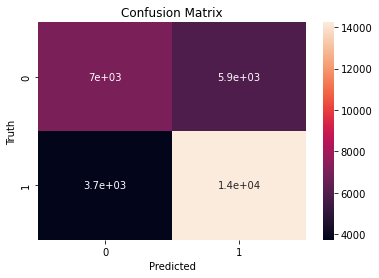

In [84]:
if round_1:
    from sklearn.metrics import confusion_matrix

    y_pred = optimal_params_r1.predict(X_test)
    #print(y_pred)
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    # Calculate percentages
    signal_correct = tp / (tp + fn) * 100  # Signal correctly classified (Recall or TPR)
    background_correct = tn / (tn + fp) * 100  # Background correctly classified (TNR)

    print(f"Signal correctly classified: {signal_correct:.2f}%")
    print(f"Background correctly classified: {background_correct:.2f}%")

    #plt.figure(figsize=(7,5))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title("Confusion Matrix")
    
    plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/confusionMatrix_plot.pdf", dpi=300)
    plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/confusionMatrix_plot.png", dpi=300)
    
    plt.show()

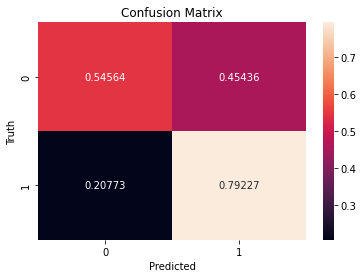

In [85]:
# Normalized confusion matrix

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# Predict and compute confusion matrix
y_pred = optimal_params_r1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

#print(cm.sum(axis=1))
# Normalize by row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
sn.heatmap(cm_normalized, annot=True, fmt=".5f")#, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/normByrow_confusionMatrix_plot.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/normByrow_confusionMatrix_plot.png", dpi=300)

plt.show()

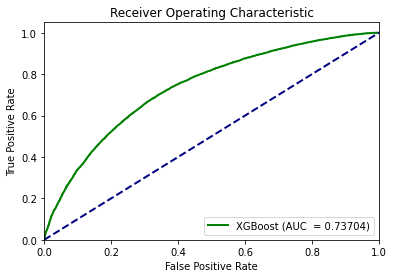

In [86]:
from sklearn.metrics import roc_curve
fpr_xgb_r1, tpr_xgb_r1, threshold = roc_curve(y_true=y_test, y_score=y_pred_r1, sample_weight=None)
plt.plot(fpr_xgb_r1, tpr_xgb_r1, color='green',lw=2, label='XGBoost (AUC  = {})'.format(np.round(auc_test_r1, decimals=5)))
#display(threshold)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/roc_test_AUC.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/roc_test_AUC.png", dpi=300)

plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate

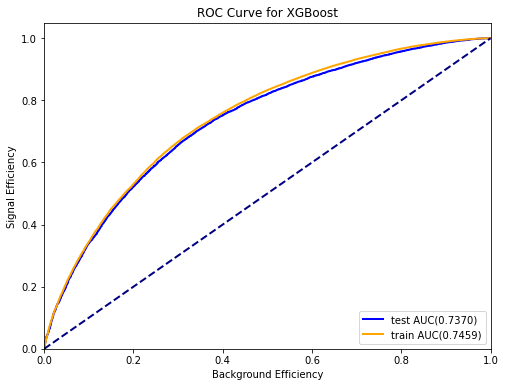

In [87]:
fpr,tpr,_ = roc_curve(y_true=y_test,y_score=y_pred_r1)
fpr1,tpr1,_ = roc_curve(y_true=y_train,y_score=y_pred_train_r1)

auc_value_train = roc_auc_score(y_true=y_train, y_score=y_pred_train_r1)
auc_value_test  = roc_auc_score(y_true=y_test, y_score=y_pred_r1)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, color='blue',lw=2,label = f'test AUC({auc_value_test:.4f})')
plt.plot(fpr1,tpr1, color='orange',lw=2,label = f'train AUC({auc_value_train:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/roc_test_and_train_AUC.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/roc_test_and_train_AUC.png", dpi=300)

plt.show()

In [88]:
int_pred_test_sig_xgb_r1 = [((y_test ==1) & (y_pred_r1 > th_cut)).sum() for th_cut in threshold]
int_pred_test_bkg_xgb_r1 = [((y_test ==0) & (y_pred_r1 > th_cut)).sum() for th_cut in threshold]

vamsasimov_xgb_r1 = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb_r1, int_pred_test_bkg_xgb_r1)]
significance_xgb_r1 = max(vamsasimov_xgb_r1) #finds the maximum significance. Which threshold results in this significance?
Z_ = significance_xgb_r1
print("Z:",Z_)

Z: 145.12924778849128


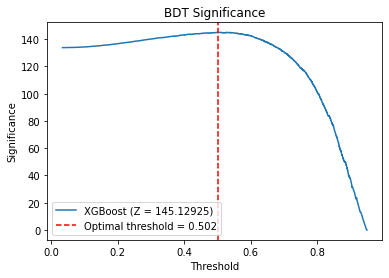

In [89]:
plt.plot(threshold, vamsasimov_xgb_r1, label='XGBoost (Z = {})'.format(np.round(significance_xgb_r1, decimals=5)))

idx_max = np.argmax(vamsasimov_xgb_r1)
opt_th = threshold[idx_max]

plt.axvline(opt_th, color='r', linestyle='--', label=f'Optimal threshold = {np.round(float(opt_th), 3)}')

plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/significance.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/significance.png", dpi=300)

plt.show()

[0.0402278  0.07551721 0.03435563 0.02968718 0.04518227 0.02918663
 0.0540547  0.02485749 0.04788075 0.06790143 0.05460627 0.05142154
 0.01885308 0.02931152 0.02308117 0.05879736 0.02848738 0.2865906 ]


,index,features,importance
0,17,eraFlag,0.286591
1,1,mindr_lep1_jet,0.075517
2,9,avg_dr_jet,0.067901
3,15,met_LD,0.058797
4,10,tau1_pt,0.054606
5,6,dr_lep1_tau_os,0.054055
6,11,mLepTauVis,0.051422
7,8,mindr_tau_jet,0.047881
8,4,mindr_lep2_jet,0.045182
9,0,lep1_conePt,0.040228


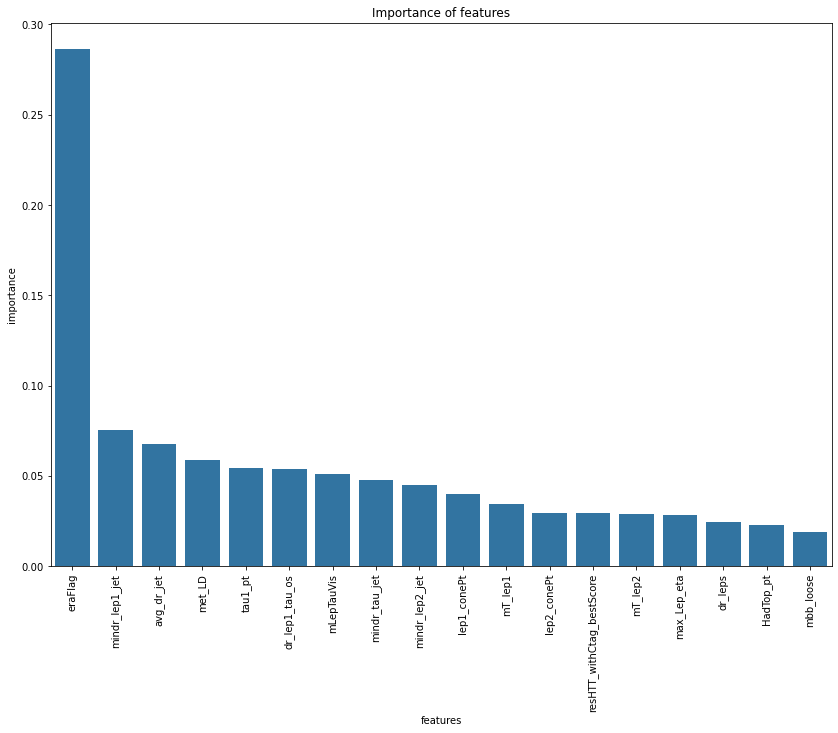

In [90]:
#importances = xgb_.feature_importances_
importances = optimal_params_r1.best_estimator_.feature_importances_
print(importances)
df_importance = pd.DataFrame( {"features": data.columns.values, "importance": importances} )
df_importance = df_importance.sort_values('importance', ascending=False).reset_index()
display(df_importance)

# Dynamic figure size based on feature count
num_features = len(df_importance)
fig_width = max(14, num_features * 0.5) 
fig_hight = 10
plt.figure(figsize=(fig_width, fig_hight))

sn.barplot(data = df_importance, x = 'features', y = 'importance')
plt.xticks(rotation=90)
plt.title("Importance of features")

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/features_importance.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/features_importance.png", dpi=300)

plt.show()

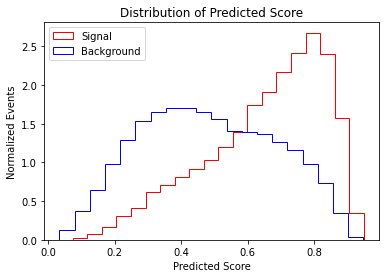

In [91]:
# Get discriminator score
#scores = loaded_model.predict_proba(X_test)[:, 1]
scores = y_pred_r1
# Plot signal vs background score distribution
#plt.hist(scores[y_test==1], bins=2, alpha=0.6, histtype='step', color='r', label='Signal', density=True)
#plt.hist(scores[y_test==0], bins=2, alpha=0.6, histtype='step', color='b', label='Background', density=True)
plt.hist(scores[y_test==1], bins=20, histtype='step', color='r', label='Signal', density=True)
plt.hist(scores[y_test==0], bins=20, histtype='step', color='b', label='Background', density=True)
plt.xlabel("Predicted Score")
plt.ylabel("Normalized Events")
plt.legend()
#plt.grid(True)
plt.title("Distribution of Predicted Score")

plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/distribution_of_predicted_scores.pdf", dpi=300)
plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/distribution_of_predicted_scores.png", dpi=300)

plt.show()

In [92]:
Do_Learning_Curve = True
if Do_Learning_Curve : 
    train_sizes = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]
    ntrains = []
    test_aucs = []
    train_aucs = []
    fpr = []
    tpr = []

    for train_size in train_sizes:
        ntrain = int(len(X_train) * train_size)
        print("training with ", ntrain, " events")
        ntrains.append(ntrain)

        # Score on test dataset (always the same)
        model_path = os.path.join("2los1tau", "model_xgboost_forSignalExtractionWithBDT_for_2los1tau_21Aug2025_NoWeight.joblib")
        loaded_model = joblib.load(model_path)
        y_pred_xgb = loaded_model.predict_proba(X_test)[:, 1]
        auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb, sample_weight=None)
        test_aucs.append(auc_test_xgb)

        # Score on the train dataset
        y_train_xgb = loaded_model.predict_proba(X_train[:ntrain])[:, 1]
        auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb, sample_weight=None)
        train_aucs.append(auc_train_xgb)

        temp_fpr, temp_tpr, _ = roc_curve(y_true=y_train[:ntrain], y_score=y_train_xgb, sample_weight=None)
        fpr.append(temp_fpr)
        tpr.append(temp_tpr)

    # Create DataFrame after the loop
    dflearning = pd.DataFrame({
        "Ntraining": ntrains,
        "test_auc": test_aucs,
        "train_auc": train_aucs,
    })
    display(dflearning)

training with  1234  events
training with  6173  events
training with  12346  events
training with  24693  events
training with  61732  events
training with  98772  events
training with  123465  events


,Ntraining,test_auc,train_auc
0,1234,0.737042,0.753056
1,6173,0.737042,0.744571
2,12346,0.737042,0.744864
3,24693,0.737042,0.747758
4,61732,0.737042,0.744884
5,98772,0.737042,0.745408
6,123465,0.737042,0.745942


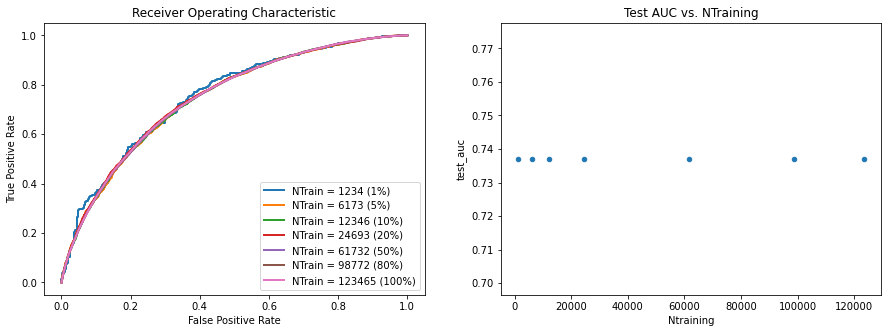

In [93]:
if Do_Learning_Curve:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    lw = 2

    for i, (fpr_i, tpr_i, ntrain_i) in enumerate(zip(fpr, tpr, ntrains)):
        train_percent = 100 * train_sizes[i]  # already defined list of fractions
        label = f'NTrain = {ntrain_i} ({train_percent:.0f}%)'
        axes[0].plot(fpr_i, tpr_i, lw=lw, label=label)

    axes[0].legend()
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic')

    axes[1].set_title("Test AUC vs. NTraining")
    dflearning.plot.scatter("Ntraining", "test_auc", ax=axes[1])

    # Save and show
    plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/learningCurve.pdf", dpi=300)
    plt.savefig("/eos/user/m/moameen/www/plots_forSignalExtraction_21Aug2025/2los1tau/learningCurve.png", dpi=300)
    
    plt.show()

In [94]:
import uproot as ur
import pandas as pd

# Input directory
inputdir = "/eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples"

# Signal samples
files_sig = {
    "2022/TTHtoNon2B.root":     f"{inputdir}/2022/TTHtoNon2B.root",
    "2022EE/TTHtoNon2B.root":   f"{inputdir}/2022EE/TTHtoNon2B.root",
    "2023/TTHtoNon2B.root":     f"{inputdir}/2023/TTHtoNon2B.root",
    "2023BPix/TTHtoNon2B.root": f"{inputdir}/2023BPix/TTHtoNon2B.root",
}

# Background samples
files_bkg = {
    "2022/TTLL_MLL_4to50.root": f"{inputdir}/2022/TTLL_MLL_4to50.root",
    "2022/TTLL_MLL_50.root":    f"{inputdir}/2022/TTLL_MLL_50.root",
    "2022/TTLNu_1Jets.root":    f"{inputdir}/2022/TTLNu_1Jets.root",
    "2022/TTto2L2Nu.root":      f"{inputdir}/2022/TTto2L2Nu.root",
    "2022/TTtoLNu2Q.root":      f"{inputdir}/2022/TTtoLNu2Q.root",
    
    "2022EE/TTLL_MLL_4to50.root": f"{inputdir}/2022EE/TTLL_MLL_4to50.root",
    "2022EE/TTLL_MLL_50.root":    f"{inputdir}/2022EE/TTLL_MLL_50.root",
    "2022EE/TTLNu_1Jets.root":    f"{inputdir}/2022EE/TTLNu_1Jets.root",
    "2022EE/TTto2L2Nu.root":      f"{inputdir}/2022EE/TTto2L2Nu.root",
    "2022EE/TTtoLNu2Q.root":      f"{inputdir}/2022EE/TTtoLNu2Q.root",
    
    "2023/TTLL_MLL_4to50.root": f"{inputdir}/2023/TTLL_MLL_4to50.root",
    "2023/TTLL_MLL_50.root":    f"{inputdir}/2023/TTLL_MLL_50.root",
    "2023/TTLNu_1Jets.root":    f"{inputdir}/2023/TTLNu_1Jets.root",
    "2023/TTto2L2Nu.root":      f"{inputdir}/2023/TTto2L2Nu.root",
    "2023/TTtoLNu2Q.root":      f"{inputdir}/2023/TTtoLNu2Q.root",
    
    "2023BPix/TTLL_MLL_4to50.root": f"{inputdir}/2023BPix/TTLL_MLL_4to50.root",
    "2023BPix/TTLL_MLL_50.root":    f"{inputdir}/2023BPix/TTLL_MLL_50.root",
    "2023BPix/TTLNu_1Jets.root":    f"{inputdir}/2023BPix/TTLNu_1Jets.root",
    "2023BPix/TTto2L2Nu.root":      f"{inputdir}/2023BPix/TTto2L2Nu.root",
    "2023BPix/TTtoLNu2Q.root":      f"{inputdir}/2023BPix/TTtoLNu2Q.root",
}

# Function to count events and split into train/test
def get_event_counts(files_dict, label):
    rows = []
    for name, path in files_dict.items():
        print(f"Loading file: {path}")
        tree = ur.open(path)["Events"]
        n_events = tree.num_entries  # fast event count
        n_train  = int(0.8 * n_events)
        n_test   = n_events - n_train
        rows.append([label, name, n_events, n_train, n_test])
    return rows

# Collect signal and background rows
rows_sig = get_event_counts(files_sig, "Signal")
rows_bkg = get_event_counts(files_bkg, "Background")

# Make DataFrame
df_summary = pd.DataFrame(
    rows_sig + rows_bkg, 
    columns=["Type", "Sample", "TotalEvents", "Train(80%)", "Test(20%)"]
)

# Totals for Signal, Background, and All
sig_totals = pd.DataFrame([[
    "TOTAL Signal", "-",
    df_summary.loc[df_summary["Type"]=="Signal", "TotalEvents"].sum(),
    df_summary.loc[df_summary["Type"]=="Signal", "Train(80%)"].sum(),
    df_summary.loc[df_summary["Type"]=="Signal", "Test(20%)"].sum()
]], columns=df_summary.columns)

bkg_totals = pd.DataFrame([[
    "TOTAL Background", "-",
    df_summary.loc[df_summary["Type"]=="Background", "TotalEvents"].sum(),
    df_summary.loc[df_summary["Type"]=="Background", "Train(80%)"].sum(),
    df_summary.loc[df_summary["Type"]=="Background", "Test(20%)"].sum()
]], columns=df_summary.columns)

all_totals = pd.DataFrame([[
    "TOTAL All", "-",
    df_summary["TotalEvents"].sum(),
    df_summary["Train(80%)"].sum(),
    df_summary["Test(20%)"].sum()
]], columns=df_summary.columns)

# Concatenate totals
df_summary = pd.concat([df_summary, sig_totals, bkg_totals, all_totals], ignore_index=True)

# Display final summary
display(df_summary)

Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022EE/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2023/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2023BPix/TTHtoNon2B.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTLL_MLL_4to50.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTLL_MLL_50.root
Loading file: /eos/cms/store/group/phys_higgs/moameen/tthmlep/signalexctraction_withBDT/2los1tau/snapshoted_ntuples/2022/TTLNu_1Jets.root
Loading file: /eos/cms/store/

,Type,Sample,TotalEvents,Train(80%),Test(20%)
0,Signal,2022/TTHtoNon2B.root,9785,7828,1957
1,Signal,2022EE/TTHtoNon2B.root,34372,27497,6875
2,Signal,2023/TTHtoNon2B.root,30335,24268,6067
3,Signal,2023BPix/TTHtoNon2B.root,15309,12247,3062
4,Background,2022/TTLL_MLL_4to50.root,913,730,183
5,Background,2022/TTLL_MLL_50.root,2113,1690,423
6,Background,2022/TTLNu_1Jets.root,221,176,45
7,Background,2022/TTto2L2Nu.root,3039,2431,608
8,Background,2022/TTtoLNu2Q.root,166,132,34
9,Background,2022EE/TTLL_MLL_4to50.root,3180,2544,636


In [98]:
if do_model_training_Bydefualt_HP:
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    xgb_final = XGBClassifier(
        objective='binary:logistic',
        tree_method = "hist",
        eval_metric='logloss',
        
        learning_rate = 0.2,
        max_depth = 4,
        min_child_weight = 400,
        reg_alpha = 0,
        reg_lambda = 1,
        subsample=0.2,
        random_state=42,
    )
    starting_time = time.time()
    xgb_final.fit(X_train, y_train.values)
    training_time = time.time( ) - starting_time
    print("Training time:",training_time)
    y_pred_xgb_final = xgb_final.predict_proba(X_test)[:,1]
    y_pred_xgb_final = y_pred_xgb_final.ravel()
    y_pred_train_xgb_final = xgb_final.predict_proba(X_train)[:,1].ravel()
    auc_test_xgb_final = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_final,sample_weight=None)
    print("auc test_final:",auc_test_xgb_final)
    print ("auc train_final:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_final, sample_weight=None),"\n")
    
    print("\n")
    print("Difference between train and test value : ", abs(auc_test_xgb_final - roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_final, sample_weight=None)))

Training time: 0.5024611949920654
auc test_final: 0.7367334961238442
auc train_final: 0.7460699218602543 



Difference between train and test value :  0.009336425736410137


In [105]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

In [106]:
# model_to_convert refers to the scikit-learn classifier to convert.
#model_to_convert = xgb_final  # model to convert
#X_test = X_test[:1]  # data used to test or train, one row is enough

In [107]:
################################################
# Set the output filename for the modified ONNX model
#output_filename = "/eos/user/m/moameen/multilepton-analysis/data/model_forSignalEctraction/2los1tau/test/output_file.onnx" # Replace with your desired output filename

In [108]:
################################################
# Step 1: Convert the model to ONNX format,
# disabling the output of labels.
# Define the input type for the ONNX model.
# The input type is a float tensor with shape
# [None, X_test.shape[1]], where None indicates that the
# number of input samples can be flexible,
# and X_test.shape[1] is the number of features for each input sample.
# A "tensor" is essentially a multi-dimensional array,
# commonly used in machine learning to represent data.
# A "float tensor" specifically contains floating-point
# numbers, which are numbers with decimals.
#initial_type = [("float_input", FloatTensorType([None, X_test.shape[1]]))]

In [110]:
'''
################################################
# Convert the model to ONNX format.
# - target_opset=18 specifies the version of ONNX operators to use.
# - options={...} sets parameters for the conversion:
#   - "zipmap": False ensures that the output is a raw array
#   - of probabilities instead of a dictionary.
#   - "output_class_labels": False ensures that the output
#     contains only probabilities, not class labels.
# ONNX (Open Neural Network Exchange) is an open format for
# representing machine learning models.
# It allows interoperability between different machine learning frameworks,
# enabling the use of models across various platforms.
onx = convert_sklearn(
    model_to_convert,
    initial_types=initial_type,
    target_opset={"": 18, "ai.onnx.ml": 3},
    options={
        id(model_to_convert): {"zipmap": False, "output_class_labels": False}
    },  # Ensures the output is only probabilities, not labels
)
'''

'\n################################################\n# Convert the model to ONNX format.\n# - target_opset=18 specifies the version of ONNX operators to use.\n# - options={...} sets parameters for the conversion:\n#   - "zipmap": False ensures that the output is a raw array\n#   - of probabilities instead of a dictionary.\n#   - "output_class_labels": False ensures that the output\n#     contains only probabilities, not class labels.\n# ONNX (Open Neural Network Exchange) is an open format for\n# representing machine learning models.\n# It allows interoperability between different machine learning frameworks,\n# enabling the use of models across various platforms.\nonx = convert_sklearn(\n    model_to_convert,\n    initial_types=initial_type,\n    target_opset={"": 18, "ai.onnx.ml": 3},\n    options={\n        id(model_to_convert): {"zipmap": False, "output_class_labels": False}\n    },  # Ensures the output is only probabilities, not labels\n)\n'

In [127]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("xgb", xgb_final)
])

X_train = X_train.copy()
X_test  = X_test.copy()

X_train.columns = [f"f{i}" for i in range(X_train.shape[1])]
X_test.columns  = [f"f{i}" for i in range(X_test.shape[1])]

pipe.fit(X_train, y_train.values)

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=400, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [128]:
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
)
import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost,
)
import onnxmltools.convert.common.data_types

In [129]:
try:
    convert_sklearn(
        pipe,
        "pipeline_xgboost",
        [("input", FloatTensorType([None, 2]))],
        target_opset={"": 12, "ai.onnx.ml": 2},
    )
except Exception as e:
    print(e)

In [130]:
update_registered_converter(
    XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)

In [131]:
model_onnx = convert_sklearn(
    pipe,
    "pipeline_xgboost",
    [("input", FloatTensorType([None, 18]))],
    target_opset={"": 12, "ai.onnx.ml": 2},
)

# And save.
with open("pipeline_xgboost.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [132]:
print("predict", pipe.predict(X_test[:5]))
print("predict_proba", pipe.predict_proba(X_test[:1]))

predict [1]
predict_proba [[0.2728858 0.7271142]]


In [140]:
import onnxruntime as rt
sess = rt.InferenceSession("pipeline_xgboost.onnx", providers=["CPUExecutionProvider"])
pred_onx = sess.run(None, {"input": X_test[:5].values.astype(np.float32)})
print("predict", pred_onx[0])
print("predict_proba", pred_onx[1][:1])

predict [1]
predict_proba [{0: 0.27288585901260376, 1: 0.7271141409873962}]


(-0.5, 2385.5, 1888.5, -0.5)

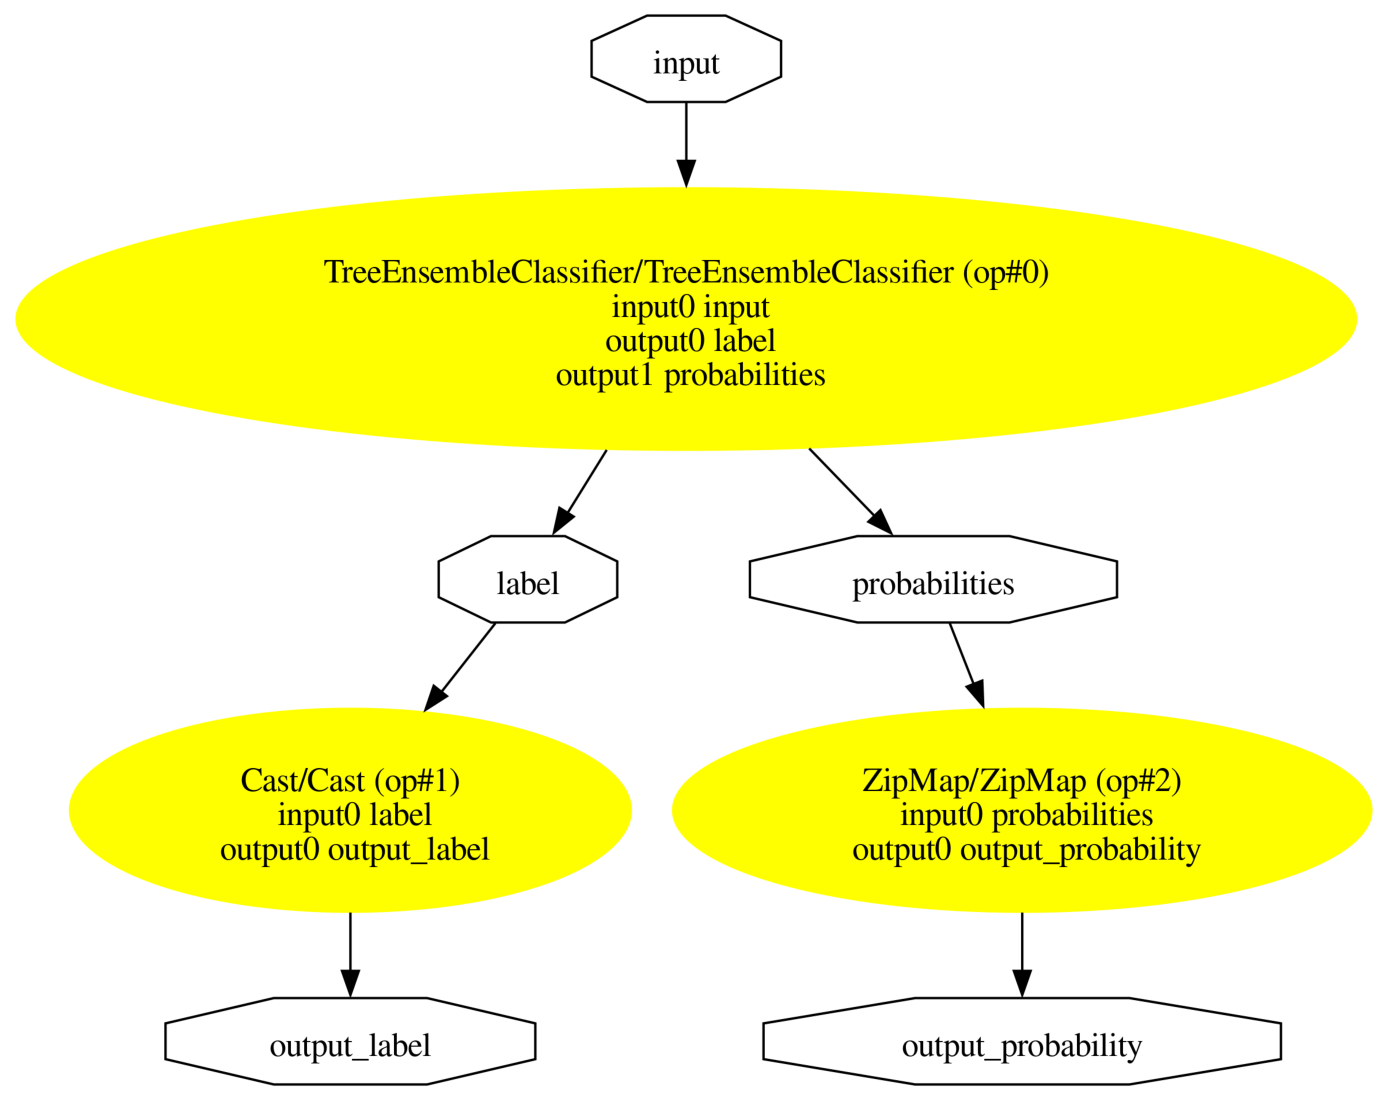

In [139]:
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
pydot_graph = GetPydotGraph(
    model_onnx.graph,
    name=model_onnx.graph.name,
    rankdir="TB",
    node_producer=GetOpNodeProducer(
        "docstring", color="yellow", fillcolor="yellow", style="filled"
    ),
)
pydot_graph.write_dot("pipeline.dot")

os.system("dot -O -Gdpi=300 -Tpng pipeline.dot")

image = plt.imread("pipeline.dot.png")
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(image)
ax.axis("off")

In [141]:
################################################
# model_to_convert refers to the scikit-learn classifier to convert.
model_to_convert = pipe  # model to convert
X_test = X_test[:1]  # data used to test or train, one row is enough

In [142]:
################################################
# Set the output filename for the modified ONNX model
output_filename = "output_file.onnx"  # Replace with your desired output filename

In [143]:
################################################
# Step 1: Convert the model to ONNX format,
# disabling the output of labels.
# Define the input type for the ONNX model.
# The input type is a float tensor with shape
# [None, X_test.shape[1]], where None indicates that the
# number of input samples can be flexible,
# and X_test.shape[1] is the number of features for each input sample.
# A "tensor" is essentially a multi-dimensional array,
# commonly used in machine learning to represent data.
# A "float tensor" specifically contains floating-point
# numbers, which are numbers with decimals.
initial_type = [("float_input", FloatTensorType([None, X_test.shape[1]]))]

In [145]:
################################################
# Convert the model to ONNX format.
# - target_opset=18 specifies the version of ONNX operators to use.
# - options={...} sets parameters for the conversion:
#   - "zipmap": False ensures that the output is a raw array
#   - of probabilities instead of a dictionary.
#   - "output_class_labels": False ensures that the output
#     contains only probabilities, not class labels.
# ONNX (Open Neural Network Exchange) is an open format for
# representing machine learning models.
# It allows interoperability between different machine learning frameworks,
# enabling the use of models across various platforms.
onx = convert_sklearn(
    model_to_convert,
    initial_types=initial_type,
    target_opset={"": 18, "ai.onnx.ml": 3},
    options={
        #id(model_to_convert): {"zipmap": False, "output_class_labels": False}
        id(model_to_convert): {"zipmap": False, "nocl": True}
    },  # Ensures the output is only probabilities, not labels
)

In [146]:
################################################
# Step 2: Load the ONNX model for further modifications if needed
# Load the ONNX model from the serialized string representation.
# An ONNX file is essentially a serialized representation of a machine learning
# model that can be shared and used across different systems.
onnx_model = onnx.load_model_from_string(onx.SerializeToString())

In [147]:
################################################
# Assuming the first output in this model should be the probability tensor
# Extract the name of the output tensor representing the probabilities.
# If there are multiple outputs, select the second one, otherwise, select the first.
prob_output_name = (
    onnx_model.graph.output[1].name
    if len(onnx_model.graph.output) > 1
    else onnx_model.graph.output[0].name
)

In [148]:
################################################
# Add a Gather node to extract only the probability
# of the positive class (index 1)
# Create a tensor to specify the index to gather
# (index 1), which represents the positive class.
indices = onnx.helper.make_tensor(
    "indices", onnx.TensorProto.INT64, (1,), [1]
)  # Index 1 to gather positive class

In [149]:
################################################
# Create a "Gather" node in the ONNX graph to extract the probability of the positive class.
# - inputs: [prob_output_name, "indices"] specify the inputs
#   to this node (probability tensor and index tensor).
# - outputs: ["positive_class_prob"] specify the name of the output of this node.
# - axis=1 indicates gathering along the columns (features) of the probability tensor.
# A "Gather" node is used to extract specific elements from a tensor.
# Here, it extracts the probability for the positive class.
gather_node = onnx.helper.make_node(
    "Gather",
    inputs=[prob_output_name, "indices"],
    outputs=["positive_class_prob"],
    axis=1,  # Gather along columns (axis 1)
)

In [150]:
################################################
# Add the Gather node to the ONNX graph
onnx_model.graph.node.append(gather_node)

In [151]:
################################################
# Add the tensor initializer for indices (needed for the Gather node)
# Initializers in ONNX are used to define constant tensors that are used in the computation.
onnx_model.graph.initializer.append(indices)

In [152]:
################################################
# Remove existing outputs and add only the new output for the positive class probability
# Clear the existing output definitions to replace them with the new output.
del onnx_model.graph.output[:]

In [153]:
################################################
# Define new output for the positive class probability
# Create a new output tensor specification with the name "positive_class_prob".
positive_class_output = onnx.helper.make_tensor_value_info(
    "positive_class_prob", onnx.TensorProto.FLOAT, [None, 1]
)
onnx_model.graph.output.append(positive_class_output)

In [154]:
################################################
# Step 3: Save the modified ONNX model
# Save the modified ONNX model to the specified output filename.
# The resulting ONNX file can then be loaded and used in different environments
# that support ONNX, such as inference servers or other machine learning frameworks.
onnx.save(onnx_model, output_filename)

In [155]:
################################################
# The model can be printed as follows.
print(onnx.printer.to_text(onnx_model))

<
   ir_version: 8,
   opset_import: ["ai.onnx.ml" : 3, "" : 18, "" : 18],
   producer_name: "skl2onnx",
   producer_version: "1.19.1",
   domain: "ai.onnx",
   model_version: 0,
   doc_string: ""
>
8bb769cd800c4ae68f5899d304f21f3e (float[?,18] float_input) => (float[?,1] positive_class_prob) 
   <int64[1] indices =  {1}>
{
   label, probabilities = ai.onnx.ml.TreeEnsembleClassifier <base_values: floats = [0.327461], class_ids: ints = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,